<a href="https://colab.research.google.com/github/LYX-AI/AI_Learning_Start_From_-Kaggle/blob/main/Getting_started_with_NLP_for_absolute_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

One area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). Computers can now generate text, translate automatically from one language to another, analyze comments, label words in sentences, and much more.

Perhaps the most widely practically useful application of NLP is *classification* -- that is, classifying a document automatically into some category. This can be used, for instance, for:

- Sentiment analysis (e.g are people saying *positive* or *negative* things about your product)
- Author identification (what author most likely wrote some document)
- Legal discovery (which documents are in scope for a trial)
- Organizing documents by topic
- Triaging inbound emails
- ...and much more!

Classification models can also be used to solve problems that are not, at first, obviously appropriate. For instance, consider the Kaggle [U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/) competition. In this, we are tasked with comparing two words or short phrases, and scoring them based on whether they're similar or not, based on which patent class they were used in. With a score of `1` it is considered that the two inputs have identical meaning, and `0` means they have totally different meaning. For instance, *abatement* and *eliminating process* have a score of `0.5`, meaning they're somewhat similar, but not identical.

It turns out that this can be represented as a classification problem. How? By representing the question like this:

> For the following text...: "TEXT1: abatement; TEXT2: eliminating process" ...chose a category of meaning similarity: "Different; Similar; Identical".

In this notebook we'll see how to solve the Patent Phrase Matching problem by treating it as a classification task, by representing it in a very similar way to that shown above.

### On Kaggle

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills. There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills. It provides:

1. Interesting data sets
1. Feedback on how you're doing
1. A leader board to see what's good, what's possible, and what's state-of-art
1. Notebooks and blog posts by winning contestants share useful tips and techniques.

The dataset we will be using here is only available from Kaggle. Therefore, you will need to register on the site, then go to the [page for the competition](https://www.kaggle.com/c/us-patent-phrase-to-phrase-matching). On that page click "Rules," then "I Understand and Accept." (Although the competition has finished, and you will not be entering it, you still have to agree to the rules to be allowed to download the data.)

There are two ways to then use this data:

- Easiest: run this notebook directly on Kaggle, or
- Most flexible: download the data locally and run it on your PC or GPU server

If you are running this on Kaggle.com, you can skip the next section. Just make sure that on Kaggle you've selected to use a GPU during your session, by clicking on the hamburger menu (3 dots in the top right) and clicking "Accelerator" -- it should look like this:

We'll need slightly different code depending on whether we're running on Kaggle or not, so we'll use this variable to track where we are:

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

### Using Kaggle data on your own machine

Kaggle limits your weekly time using a GPU machine. The limits are very generous, but you may well still find it's not enough! In that case, you'll want to use your own GPU server, or a cloud server such as Colab, Paperspace Gradient, or SageMaker Studio Lab (all of which have free options). To do so, you'll need to be able to download Kaggle datasets.

The easiest way to download Kaggle datasets is to use the Kaggle API. You can install this using `pip` by running this in a notebook cell:

    !pip install kaggle

You need an API key to use the Kaggle API; to get one, click on your profile picture on the Kaggle website, and choose My Account, then click Create New API Token. This will save a file called *kaggle.json* to your PC. You need to copy this key on your GPU server. To do so, open the file you downloaded, copy the contents, and paste them in the following cell (e.g., `creds = '{"username":"xxx","key":"xxx"}'`):

In [ ]:
creds = ''

Then execute this cell (this only needs to be run once):

In [ ]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Now you can download datasets from Kaggle.

In [ ]:
path = Path('us-patent-phrase-to-phrase-matching')

And use the Kaggle API to download the dataset to that path, and extract it:

In [ ]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

Note that you can easily download notebooks from Kaggle and upload them to other cloud services. So if you're low on Kaggle GPU credits, give this a try!

## Import and EDA

In [ ]:
import sys
from pathlib import Path

# Âà§Êñ≠ÊòØÂê¶Âú® Kaggle ÁéØÂ¢É
iskaggle = 'kaggle' in sys.modules

if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
else:
    # Colab ‰∏äÁöÑÊï∞ÊçÆË∑ØÂæÑÔºåÂÅáËÆæ‰Ω†‰∏ä‰º†Êàñ‰∏ãËΩΩÂà∞ËøôÈáå
    path = Path('/content/sample_data')

# ÂÆâË£Ö‰æùËµñÂ∫ìÔºåColab Âíå Kaggle ÈÉΩÈÄÇÁî®
!pip install -q datasets


Documents in NLP datasets are generally in one of two main forms:

- **Larger documents**: One text file per document, often organised into one folder per category
- **Smaller documents**: One document (or document pair, optionally with metadata) per row in a [CSV file](https://realpython.com/python-csv/).

Let's look at our data and see what we've got. In Jupyter you can use any bash/shell command by starting a line with a `!`, and use `{}` to include python variables, like so:

In [ ]:
!ls {path}

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


It looks like this competition uses CSV files. For opening, manipulating, and viewing CSV files, it's generally best to use the Pandas library, which is explained brilliantly in [this book](https://wesmckinney.com/book/) by the lead developer (it's also an excellent introduction to matplotlib and numpy, both of which I use in this notebook). Generally it's imported as the abbreviation `pd`.

In [ ]:
import pandas as pd

Let's set a path to our data:

In [ ]:
'''
pd ÊòØ Pandas Â∫ìÁöÑÂà´ÂêçÔºåread_csv ÊòØ Pandas ‰∏≠Áî®‰∫éËØªÂèñ CSV Êñá‰ª∂ÁöÑÂáΩÊï∞„ÄÇ

path ÊòØ‰∏Ä‰∏™ Path ÂØπË±°ÔºåË°®Á§∫Êï∞ÊçÆÊâÄÂú®ÁöÑÁõÆÂΩïË∑ØÂæÑ„ÄÇ

path / 'train.csv' Ë°®Á§∫Âú® path Ë∑ØÂæÑ‰∏ãÁöÑÊñá‰ª∂ train.csvÔºåËøôÊòØÁî® Python pathlib Â∫ìÊãºÊé•Ë∑ØÂæÑÁöÑÂÜôÊ≥ïÔºåÁõ∏ÂΩì‰∫éÂ≠óÁ¨¶‰∏≤ÊãºÊé• path + '/train.csv'„ÄÇ

pd.read_csv() ‰ºöËØªÂèñÊåáÂÆöË∑ØÂæÑÁöÑ CSV Êñá‰ª∂ÂÜÖÂÆπÔºåËøîÂõû‰∏Ä‰∏™ Pandas ÁöÑ DataFrame ÂØπË±°ÔºåÂ≠òÂÇ®ËØ• CSV Êñá‰ª∂‰∏≠ÁöÑË°®Ê†ºÊï∞ÊçÆ„ÄÇ

df ÊòØÂèòÈáèÂêçÔºåË°®Á§∫Â≠òÊîæËØªÂèñÂêéÊï∞ÊçÆÁöÑË°®Ê†ºÔºåÊñπ‰æøÂêéÁª≠Êï∞ÊçÆÊìç‰Ωú„ÄÅÂàÜÊûêÂíåÂ§ÑÁêÜ„ÄÇ
'''
df = pd.read_csv(path/'california_housing_test.csv')

This creates a [DataFrame](https://pandas.pydata.org/docs/user_guide/10min.html), which is a table of named columns, a bit like a database table. To view the first and last rows, and row count of a DataFrame, just type its name:

In [ ]:
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0       -122.05     37.37                27.0       3885.0           661.0   
1       -118.30     34.26                43.0       1510.0           310.0   
2       -117.81     33.78                27.0       3589.0           507.0   
3       -118.36     33.82                28.0         67.0            15.0   
4       -119.67     36.33                19.0       1241.0           244.0   
...         ...       ...                 ...          ...             ...   
2995    -119.86     34.42                23.0       1450.0           642.0   
2996    -118.14     34.06                27.0       5257.0          1082.0   
2997    -119.70     36.30                10.0        956.0           201.0   
2998    -117.12     34.10                40.0         96.0            14.0   
2999    -119.63     34.42                42.0       1765.0           263.0   

      population  households  median_income  median_house_value  
0         1537.0       606.0         6.6085            344700.0  
1          809.0       277.0         3.5990            176500.0  
2         1484.0       495.0         5.7934            270500.0  
3           49.0        11.0         6.1359            330000.0  
4          850.0       237.0         2.9375             81700.0  
...          ...         ...            ...                 ...  
2995      1258.0       607.0         1.1790            225000.0  
2996      3496.0      1036.0         3.3906            237200.0  
2997       693.0       220.0         2.2895             62000.0  
2998        46.0        14.0         3.2708            162500.0  
2999       753.0       260.0         8.5608            500001.0  

[3000 rows x 9 columns]

It's important to carefully read the [dataset description](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data) to understand how each of these columns is used.

One of the most useful features of `DataFrame` is the `describe()` method:

In [ ]:
'''
describe() ÈªòËÆ§ÂØπÊï∞ÂÄºÂûãÊï∞ÊçÆÂÅöÁªüËÆ°Ê±áÊÄªÔºåÊØîÂ¶ÇËÆ°Êï∞ÔºàcountÔºâ„ÄÅÂùáÂÄºÔºàmeanÔºâ„ÄÅÊ†áÂáÜÂ∑ÆÔºàstdÔºâ„ÄÅÊúÄÂ∞èÂÄºÔºàminÔºâ„ÄÅÂõõÂàÜ‰ΩçÊï∞Ôºà25%„ÄÅ50%„ÄÅ75%ÔºâÂíåÊúÄÂ§ßÂÄºÔºàmaxÔºâ„ÄÇ

ÂΩì‰Ω†ÊåáÂÆöÂèÇÊï∞ include='object'ÔºåË°®Á§∫Âè™ÂØπÊï∞ÊçÆÁ±ªÂûã‰∏∫‚Äúobject‚ÄùÔºàÈÄöÂ∏∏ÊåáÂ≠óÁ¨¶‰∏≤ÊàñÁ±ªÂà´ÂûãÊï∞ÊçÆÔºâÁöÑÂàóËøõË°åÁªüËÆ°ÊèèËø∞„ÄÇ

ÁªüËÆ°ÁªìÊûú‰∏ÄËà¨ÂåÖÂê´
countÔºöÈùûÁ©∫ÂÄºÁöÑÊï∞Èáè

uniqueÔºö‰∏çÂêåÂÄºÁöÑ‰∏™Êï∞

topÔºöÂá∫Áé∞È¢ëÁéáÊúÄÈ´òÁöÑÂÄºÔºà‰ºóÊï∞Ôºâ

freqÔºöÊúÄÈ´òÈ¢ëÂÄºÂá∫Áé∞ÁöÑÊ¨°Êï∞
'''
df['total_rooms'].describe()

count     3000.000000
mean      2599.578667
std       2155.593332
min          6.000000
25%       1401.000000
50%       2106.000000
75%       3129.000000
max      30450.000000
Name: total_rooms, dtype: float64

We can see that in the 36473 rows, there are 733 unique anchors, 106 contexts, and nearly 30000 targets. Some anchors are very common, with "component composite coating" for instance appearing 152 times.

Earlier, I suggested we could represent the input to the model as something like "*TEXT1: abatement; TEXT2: eliminating process*". We'll need to add the context to this too. In Pandas, we just use `+` to concatenate, like so:

In [ ]:
df['description'] = (
    'Location: (' + df['longitude'].astype(str) + ', ' + df['latitude'].astype(str) + '); ' +
    'Median house value: $' + df['median_house_value'].astype(str)
)
print(df[['longitude', 'latitude', 'median_house_value', 'description']])

      longitude  latitude  median_house_value  \
0       -122.05     37.37            344700.0   
1       -118.30     34.26            176500.0   
2       -117.81     33.78            270500.0   
3       -118.36     33.82            330000.0   
4       -119.67     36.33             81700.0   
...         ...       ...                 ...   
2995    -119.86     34.42            225000.0   
2996    -118.14     34.06            237200.0   
2997    -119.70     36.30             62000.0   
2998    -117.12     34.10            162500.0   
2999    -119.63     34.42            500001.0   

                                            description  
0     Location: (-122.05, 37.37); Median house value...  
1     Location: (-118.3, 34.26); Median house value:...  
2     Location: (-117.81, 33.78); Median house value...  
3     Location: (-118.36, 33.82); Median house value...  
4     Location: (-119.67, 36.33); Median house value...  
...                                                 ...  
2995 

We can refer to a column (also known as a *series*) either using regular python "dotted" notation, or access it like a dictionary. To get the first few rows, use `head()`:

In [ ]:
df['total_rooms'].head()

0    3885.0
1    1510.0
2    3589.0
3      67.0
4    1241.0
Name: total_rooms, dtype: float64

## Tokenization

Transformers uses a `Dataset` object for storing a... well a dataset, of course! We can create one like so:

In [ ]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

Here's how it's displayed in a notebook:

In [ ]:
ds

Dataset({
    features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'description'],
    num_rows: 3000
})

But we can't pass the texts directly into a model. A deep learning model expects numbers as inputs, not English sentences! So we need to do two things:

- *Tokenization*: Split each text up into words (or actually, as we'll see, into *tokens*)
- *Numericalization*: Convert each word (or token) into a number.

The details about how this is done actually depend on the particular model we use. So first we'll need to pick a model. There are thousands of models available, but a reasonable starting point for nearly any NLP problem is to use this (replace "small" with "large" for a slower but more accurate model, once you've finished exploring):

In [ ]:
'''
Ëøô‰∏™Â≠óÁ¨¶‰∏≤ÊòØ Hugging Face Ê®°ÂûãÂ∫ìÔºàModel HubÔºâÈáåÈ¢ÑËÆ≠ÁªÉÊ®°ÂûãÁöÑ‚ÄúÂú∞ÂùÄ‚ÄùÊàñ‚ÄúÂêçÂ≠ó‚Äù„ÄÇ
'''
model_nm = 'microsoft/deberta-v3-small'

`AutoTokenizer` will create a tokenizer appropriate for a given model:

In [ ]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Here's an example of how the tokenizer splits a text into "tokens" (which are like words, but can be sub-word pieces, as you see below):

In [ ]:
tokz.tokenize("G'day folks, I'm Pino from fast.ai!")

['‚ñÅG',
 "'",
 'day',
 '‚ñÅfolks',
 ',',
 '‚ñÅI',
 "'",
 'm',
 '‚ñÅPino',
 '‚ñÅfrom',
 '‚ñÅfast',
 '.',
 'ai',
 '!']

Uncommon words will be split into pieces. The start of a new word is represented by `‚ñÅ`:

In [ ]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['‚ñÅA',
 '‚ñÅplatypus',
 '‚ñÅis',
 '‚ñÅan',
 '‚ñÅor',
 'ni',
 'tho',
 'rhynch',
 'us',
 '‚ñÅan',
 'at',
 'inus',
 '.']

Here's a simple function which tokenizes our inputs:

In [ ]:
def tok_func(x):
  return tokz(x["description"])

In [ ]:
print(tok_ds[:5])  # Êü•ÁúãÂâç5Êù°Êï∞ÊçÆ

{'longitude': [-122.05, -118.3, -117.81, -118.36, -119.67], 'latitude': [37.37, 34.26, 33.78, 33.82, 36.33], 'housing_median_age': [27.0, 43.0, 27.0, 28.0, 19.0], 'total_rooms': [3885.0, 1510.0, 3589.0, 67.0, 1241.0], 'total_bedrooms': [661.0, 310.0, 507.0, 15.0, 244.0], 'population': [1537.0, 809.0, 1484.0, 49.0, 850.0], 'households': [606.0, 277.0, 495.0, 11.0, 237.0], 'median_income': [6.6085, 3.599, 5.7934, 6.1359, 2.9375], 'median_house_value': [344700.0, 176500.0, 270500.0, 330000.0, 81700.0], 'description': ['Location: (-122.05, 37.37); Median house value: $344700.0', 'Location: (-118.3, 34.26); Median house value: $176500.0', 'Location: (-117.81, 33.78); Median house value: $270500.0', 'Location: (-118.36, 33.82); Median house value: $330000.0', 'Location: (-119.67, 36.33); Median house value: $81700.0'], 'input_ids': [[1, 7792, 294, 287, 271, 23267, 260, 3586, 261, 4249, 260, 5422, 285, 346, 52014, 669, 772, 294, 419, 38714, 7372, 260, 693, 2], [1, 7792, 294, 287, 271, 23562, 

To run this quickly in parallel on every row in our dataset, use `map`:

In [ ]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

This adds a new item to our dataset called `input_ids`. For instance, here is the input and IDs for the first row of our data:

In [ ]:
row = tok_ds[0]
row['longitude'], row['input_ids']


(-122.05,
 [1,
  7792,
  294,
  287,
  271,
  23267,
  260,
  3586,
  261,
  4249,
  260,
  5422,
  285,
  346,
  52014,
  669,
  772,
  294,
  419,
  38714,
  7372,
  260,
  693,
  2])

So, what are those IDs and where do they come from? The secret is that there's a list called `vocab` in the tokenizer which contains a unique integer for every possible token string. We can look them up like this, for instance to find the token for the word "of":

In [ ]:
tokz.vocab['‚ñÅof']

265

Looking above at our input IDs, we do indeed see that `265` appears as expected.

Finally, we need to prepare our labels. Transformers always assumes that your labels has the column name `labels`, but in our dataset it's currently `score`. Therefore, we need to rename it:

In [ ]:
# tok_ds = tok_ds.rename_columns({'latitude':'labels'})
print(tok_ds.column_names)
print(tok_ds)

['longitude', 'labels', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'description', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset({
    features: ['longitude', 'labels', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'description', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


Now that we've prepared our tokens and labels, we need to create our validation set.

## Test and validation sets

You may have noticed that our directory contained another file:

In [ ]:
eval_df = pd.read_csv(path/'california_housing_test.csv')
eval_df.describe()

longitude    latitude  housing_median_age   total_rooms  \
count  3000.000000  3000.00000         3000.000000   3000.000000   
mean   -119.589200    35.63539           28.845333   2599.578667   
std       1.994936     2.12967           12.555396   2155.593332   
min    -124.180000    32.56000            1.000000      6.000000   
25%    -121.810000    33.93000           18.000000   1401.000000   
50%    -118.485000    34.27000           29.000000   2106.000000   
75%    -118.020000    37.69000           37.000000   3129.000000   
max    -114.490000    41.92000           52.000000  30450.000000   

       total_bedrooms    population  households  median_income  \
count     3000.000000   3000.000000  3000.00000    3000.000000   
mean       529.950667   1402.798667   489.91200       3.807272   
std        415.654368   1030.543012   365.42271       1.854512   
min          2.000000      5.000000     2.00000       0.499900   
25%        291.000000    780.000000   273.00000       2.544000   
50%        437.000000   1155.000000   409.50000       3.487150   
75%        636.000000   1742.750000   597.25000       4.656475   
max       5419.000000  11935.000000  4930.00000      15.000100   

       median_house_value  
count          3000.00000  
mean         205846.27500  
std          113119.68747  
min           22500.00000  
25%          121200.00000  
50%          177650.00000  
75%          263975.00000  
max          500001.00000

This is the *test set*. Possibly the most important idea in machine learning is that of having separate training, validation, and test data sets.

### Validation set

To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

In [5]:
def f(x): return -3*x**2 + 2*x + 20

Unfortunately matplotlib (the most common library for plotting in Python) doesn't come with a way to visualize a function, so we'll write something to do this ourselves:

In [6]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

Here's what our function looks like:

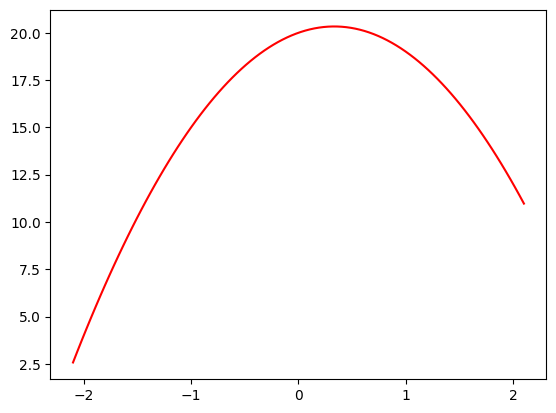

In [ ]:
plot_function(f)

In [ ]:
import numpy as np

# ÁîüÊàê‰∏ÄÁª¥Êï∞ÁªÑÔºåÈïøÂ∫¶‰∏∫5
a = np.array([1, 2, 3, 4, 5])
print("a shape:", a.shape)  # (5,)

# Áªô‰∏ÄÁª¥Êï∞ÁªÑÂä†‰∏Ä‰∏™Êñ∞Áª¥Â∫¶ÔºåÂèòÊàêÂàóÂêëÈáè (5, 1)
a_col = a[:, None]
print("a_col shape:", a_col.shape)  # (5, 1)

# Áªô‰∏ÄÁª¥Êï∞ÁªÑÂä†‰∏Ä‰∏™Êñ∞Áª¥Â∫¶ÔºåÂèòÊàêË°åÂêëÈáè (1, 5)
a_row = a[None, :]
print("a_row shape:", a_row.shape)  # (1, 5)

# Áõ¥Êé•Áî®‰∏ÄÁª¥Êï∞ÁªÑÂÅöÁü©Èòµ‰πòÊ≥ï‰ºöÊä•Èîô
try:
    result = a @ a  # ÈîôËØØÔºå1DÊï∞ÁªÑ‰∏çËÉΩÁõ¥Êé•Áî®@‰πòÊ≥ï
except Exception as e:
    print("a @ a error:", e)

# ‰ΩøÁî®‰∫åÁª¥ÂàóÂêëÈáèÂíå‰∫åÁª¥Ë°åÂêëÈáèÂÅöÁü©Èòµ‰πòÊ≥ïÔºåÂæóÂà∞Ê≠£Â∏∏ÁªìÊûú (5, 5) Áü©Èòµ
result = a_col @ a_row
print("a_col @ a_row result shape:", result.shape)
print(result)
'''
Â•ΩÁöÑÔºåÁªô‰Ω†ËÆ≤Ëß£‰∏Ä‰∏ã„ÄåÂΩ¢Áä∂„ÄçÊòØ‰ªÄ‰πàÊÑèÊÄùÔºåÁâπÂà´ÊòØ `(5,)` ËøôÁßçÂÜôÊ≥ïÔºö

---

### 1. ‰ªÄ‰πàÊòØÊï∞ÁªÑÁöÑ„ÄåÂΩ¢Áä∂„ÄçÔºàShapeÔºâÔºü

Âú® NumPy ÈáåÔºåÊï∞ÁªÑÔºàndarrayÔºâÊòØÂ§öÁª¥Êï∞ÊçÆÁöÑÈõÜÂêà„ÄÇÂΩ¢Áä∂Áî®‰∏Ä‰∏™„ÄåÂÖÉÁªÑ„ÄçË°®Á§∫ÔºåÂëäËØâ‰Ω†Ëøô‰∏™Êï∞ÁªÑÊúâÂ§öÂ∞ë‰∏™Áª¥Â∫¶ÔºåÊØè‰∏™Áª¥Â∫¶ÁöÑÈïøÂ∫¶ÊòØÂ§öÂ∞ë„ÄÇ

‰∏æ‰∏™‰æãÂ≠êÔºö

* ‰∏ÄÁª¥Êï∞ÁªÑÔºåÂÉè‰∏ÄÊù°Á∫øÔºåÂΩ¢Áä∂ÊòØ `(5,)` ÔºåË°®Á§∫Âè™Êúâ‰∏Ä‰∏™Áª¥Â∫¶ÔºåÈïøÂ∫¶ÊòØ 5Ôºå‰πüÂ∞±ÊòØÊúâ5‰∏™ÂÖÉÁ¥†„ÄÇ
* ‰∫åÁª¥Êï∞ÁªÑÔºåÂÉè‰∏Ä‰∏™Ë°®Ê†ºÔºàÁü©ÈòµÔºâÔºåÂΩ¢Áä∂ÂèØËÉΩÊòØ `(3, 4)`ÔºåË°®Á§∫Êúâ 3 Ë°åÔºå4 Âàó„ÄÇ
* ‰∏âÁª¥Êï∞ÁªÑÔºåÂΩ¢Áä∂ÂèØËÉΩÊòØ `(2, 3, 4)`ÔºåÂ∞±ÂÉè 2 Âº† 3√ó4 ÁöÑË°®Ê†ºÂ†ÜËµ∑Êù•„ÄÇ

---

### 2. `(5,)` Âíå `(5,1)`„ÄÅ`(1,5)` ÁöÑÂå∫Âà´

* `(5,)`Ôºö‰∏ÄÁª¥Êï∞ÁªÑÔºåÊúâ5‰∏™ÂÖÉÁ¥†ÔºåÊØîÂ¶Ç `[1, 2, 3, 4, 5]`ÔºåÊ≤°ÊúâÊòéÁ°ÆÁöÑË°åÊàñÂàóÊ¶ÇÂøµÔºåÂè™ÊòØ5‰∏™Êï∞Â≠óÊéíÊàê‰∏ÄÊù°Á∫ø„ÄÇ

* `(5,1)`Ôºö‰∫åÁª¥Êï∞ÁªÑÔºåÊúâ5Ë°åÔºå1ÂàóÔºå‰πüÂ∞±ÊòØ‚ÄúÂàóÂêëÈáè‚ÄùÔºåÈïøËøôÊ†∑Ôºö

  ```
  [[1],
   [2],
   [3],
   [4],
   [5]]
  ```

* `(1,5)`Ôºö‰∫åÁª¥Êï∞ÁªÑÔºåÊúâ1Ë°åÔºå5ÂàóÔºå‰πüÂ∞±ÊòØ‚ÄúË°åÂêëÈáè‚ÄùÔºåÈïøËøôÊ†∑Ôºö

  ```
  [[1, 2, 3, 4, 5]]
  ```

---

### 3. ‰∏∫‰ªÄ‰πàË¶ÅÂå∫ÂàÜËøô‰∫õÂΩ¢Áä∂Ôºü

ÂæàÂ§öÊï∞Â≠¶ËøêÁÆóÔºåÊØîÂ¶ÇÁü©Èòµ‰πòÊ≥ï„ÄÅÂπøÊí≠Á≠âÔºåÈÉΩ‰æùËµñÊï∞ÁªÑÁöÑÂΩ¢Áä∂ÔºåÂΩ¢Áä∂‰∏çÂêåÁªìÊûúÂ∞±‰ºö‰∏ç‰∏ÄÊ†∑ÔºåÁîöËá≥‰ºöÊä•Èîô„ÄÇ

‰∏æ‰∏™‰æãÂ≠êÔºå‰∫åÁª¥ÁöÑ `(5,1)` Ë∑ü `(1,5)` Áü©ÈòµÁõ∏‰πòÔºåËÉΩÂæóÂà∞‰∏Ä‰∏™ 5 Ë°å 5 ÂàóÁöÑÁü©ÈòµÔºåËÄå‰∏ÄÁª¥Êï∞ÁªÑ `(5,)` ‰∏çËÉΩÁõ¥Êé•ÂÅöÁü©Èòµ‰πòÊ≥ï„ÄÇ

---

### ÊÄªÁªì

* Êï∞ÁªÑÁöÑ„ÄåÂΩ¢Áä∂„ÄçÂëäËØâ‰Ω†Êï∞ÁªÑÊúâÂá†Áª¥ÔºåÊØèÁª¥ÊúâÂ§öÂ∞ë‰∏™ÂÖÉÁ¥†„ÄÇ
* `(5,)` ÊòØ‰∏ÄÁª¥Êï∞ÁªÑÔºå5‰∏™ÂÖÉÁ¥†„ÄÇ
* `(5,1)` ÊòØ‰∫åÁª¥Êï∞ÁªÑÔºå5Ë°å1Âàó„ÄÇ
* `(1,5)` ÊòØ‰∫åÁª¥Êï∞ÁªÑÔºå1Ë°å5Âàó„ÄÇ
* ÂΩ¢Áä∂‰∏çÂêåÔºåÂæàÂ§öËøêÁÆóÁöÑËßÑÂàô‰πü‰∏çÂêå„ÄÇ

---

‰Ω†ÂèØ‰ª•ÊääÂΩ¢Áä∂ÊÉ≥Ë±°Êàê„ÄåÊï∞ÊçÆÁöÑÂ∞∫ÂØ∏ÂíåÊéíÂ∏É„ÄçÔºÅÈúÄË¶ÅÊàëÂ∏Æ‰Ω†Áî®ÂõæÂΩ¢ÁîªÂá∫Êù•Êõ¥Áõ¥ËßÇÂú∞Ëß£ÈáäÂêóÔºü

'''


a shape: (5,)
a_col shape: (5, 1)
a_row shape: (1, 5)
a_col @ a_row result shape: (5, 5)
[[ 1  2  3  4  5]
 [ 2  4  6  8 10]
 [ 3  6  9 12 15]
 [ 4  8 12 16 20]
 [ 5 10 15 20 25]]


For instance, perhaps we've measured the height above ground of an object before and after some event. The measurements will have some random error. We can use numpy's random number generator to simulate that. I like to use `seed` when writing about simulations like this so that I know you'll see the same thing I do:

In [7]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

Here's a function `add_noise` that adds some random variation to an array:

In [9]:
def noise(x, scale):
  return normal(scale=scale, size=x.shape)#scaleÔºö‰∏Ä‰∏™Êï∞ÂÄºÔºåË°®Á§∫Ê≠£ÊÄÅÂàÜÂ∏ÉÁöÑÊ†áÂáÜÂ∑ÆÔºànoise ÁöÑÂº∫Â∫¶ÔºâÊ†áÂáÜÂ∑ÆÔºàstd or scaleÔºâÔºöÊï∞ÊçÆÁöÑÊ≥¢Âä®ËåÉÂõ¥ÔºåË∂äÂ§ßË°®Á§∫Êï∞ÊçÆË∂äÂàÜÊï£
def add_noise(x, mult, add):
  return x * (1+noise(x,mult)) + noise(x,add)
'''
ÂΩìÁÑ∂ÔºÅÊàëÊù•Â∏Æ‰Ω†ËØ¶ÁªÜËÆ≤Ëß£ `add_noise` Ëøô‰∏™ÂáΩÊï∞ÁöÑÂê´‰πâÂíåÂÜÖÈÉ®Êú∫Âà∂„ÄÇ

---

### ÂáΩÊï∞‰ª£Á†ÅÂõûÈ°æÔºö

```python
def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)
```

---

### ÂèÇÊï∞ËØ¥ÊòéÔºö

* `x`ÔºöËæìÂÖ•ÁöÑÂéüÂßãÊï∞ÊçÆÊï∞ÁªÑÔºànumpy arrayÔºâÔºåÊØîÂ¶ÇÂáΩÊï∞ËÆ°ÁÆóÂæóÂà∞ÁöÑÁêÜÊÉ≥Êï∞ÊçÆ„ÄÇ
* `mult`Ôºö‰πòÊ≥ïÂô™Â£∞ÁöÑÊ†áÂáÜÂ∑ÆÔºàscaleÔºâÔºåÊéßÂà∂‚ÄúÁõ∏ÂØπËØØÂ∑Æ‚ÄùÁöÑÂº∫Â∫¶„ÄÇ
* `add`ÔºöÂä†Ê≥ïÂô™Â£∞ÁöÑÊ†áÂáÜÂ∑ÆÔºåÊéßÂà∂‚ÄúÁªùÂØπËØØÂ∑Æ‚ÄùÁöÑÂº∫Â∫¶„ÄÇ

---

### ÂáΩÊï∞ÂäüËÉΩÔºö

Ëøô‰∏™ÂáΩÊï∞ÊòØÂú®ÁªôÂéüÂßãÊï∞ÊçÆ `x` Â¢ûÂä†Âô™Â£∞ÔºàÊâ∞Âä®ÔºâÔºåÊ®°ÊãüÁé∞ÂÆû‰∏≠ÊµãÈáèÊàñÊï∞ÊçÆÈááÈõÜÊó∂Â≠òÂú®ÁöÑËØØÂ∑Æ„ÄÇ

---

### ÂÖ∑‰ΩìËøáÁ®ãÊãÜËß£Ôºö

1. `noise(x, mult)`

   * ‰∫ßÁîü‰∏Ä‰∏™Âíå `x` ÂΩ¢Áä∂Áõ∏ÂêåÁöÑÊ≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞Êï∞ÁªÑÔºåÊ†áÂáÜÂ∑Æ‰∏∫ `mult`„ÄÇ
   * Ëøô‰ª£Ë°®‚ÄúÁõ∏ÂØπËØØÂ∑Æ‚ÄùÔºåÂõ†‰∏∫ÂêéÁª≠‰ºö‰πòÂà∞ `x` ‰∏ä„ÄÇ

2. `1 + noise(x, mult)`

   * ÁªôËØØÂ∑ÆÂä†‰∏ä 1ÔºåË°®Á§∫‚Äú‰ª•1‰∏∫Âü∫ÂáÜÔºå‰∏ä‰∏ãÊ≥¢Âä®‚ÄùÔºåÊØîÂ¶Ç 1.05 Ë°®Á§∫Âú® `x` ‰∏äÂ¢ûÂä†5%„ÄÇ

3. `x * (1 + noise(x, mult))`

   * ÊääËøô‰∏™Â∏¶ÈöèÊú∫Êâ∞Âä®ÁöÑÊØî‰æã‰πò‰ª• `x`ÔºåÁõ∏ÂΩì‰∫éÂØπ `x` ÂÅö**ÊØî‰æãÊâ∞Âä®**„ÄÇ
   * ‰æãÂ¶ÇÔºå`x=100`ÔºåÊØî‰æãÊâ∞Âä®ÊòØ0.05ÔºåÂàôÁªìÊûúÊòØ105„ÄÇ

4. `noise(x, add)`

   * ‰∫ßÁîüÂè¶‰∏ÄÁªÑÊ≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Âô™Â£∞ÔºåÊ†áÂáÜÂ∑Æ‰∏∫ `add`ÔºåË°®Á§∫**Âä†Ê≥ïËØØÂ∑Æ**Ôºå‰∏çÈöè `x` Â§ßÂ∞èÂèòÂåñ„ÄÇ
   * ËøôÂ∞±ÂÉèÊµãÈáè‰ª™Âô®ÁöÑÂõ∫ÂÆöËØØÂ∑ÆÔºåÊØîÂ¶ÇÊ∏©Â∫¶ËÆ°ËØØÂ∑Æ ¬±1Â∫¶„ÄÇ

5. ÊúÄÁªàËøîÂõûÔºö

   $$
   \text{ËæìÂá∫} = x \times (1 + \text{Áõ∏ÂØπËØØÂ∑Æ}) + \text{ÁªùÂØπËØØÂ∑Æ}
   $$

---

### ÂΩ¢Ë±°ÁêÜËß£Ôºö

* `mult` ÊéßÂà∂Êï∞ÊçÆÁöÑ‚Äú**ÊØî‰æãÂô™Â£∞**‚ÄùÔºåÊØîÂ¶Ç 5% ÁöÑÊ≥¢Âä®„ÄÇ
* `add` ÊéßÂà∂Êï∞ÊçÆÁöÑ‚Äú**Âõ∫ÂÆöÂô™Â£∞**‚ÄùÔºåÊØîÂ¶Ç ¬±1 Âçï‰ΩçÁöÑËØØÂ∑Æ„ÄÇ
* ‰∏§ÁßçËØØÂ∑ÆÂêàËµ∑Êù•ÔºåÊõ¥ÁúüÂÆûÂú∞Ê®°ÊãüÁé∞ÂÆû‰∏≠Êï∞ÊçÆÊµãÈáèÁöÑÂ§çÊùÇÊÉÖÂÜµ„ÄÇ

---

### ‰∏æ‰æãÔºö

ÂÅáËÆæ `x = 100`Ôºå`mult=0.1`Ôºà10%ÊØî‰æãËØØÂ∑ÆÔºâÔºå`add=2`Ôºà¬±2Âçï‰ΩçËØØÂ∑ÆÔºâÔºå‰∏ÄÊ¨°ÈöèÊú∫Ë∞ÉÁî®ÂèØËÉΩ‰∫ßÁîüÔºö

* ÊØî‰æãÂô™Â£∞Ôºö`noise(x, 0.1)` ÁîüÊàê‰∫Ü `0.08`ÔºåÊâÄ‰ª•‰πòÊï∞ÊòØ `1 + 0.08 = 1.08`
* Âä†Ê≥ïÂô™Â£∞Ôºö`noise(x, 2)` ÁîüÊàê‰∫Ü `-1.5`
* ËÆ°ÁÆóÁªìÊûúÊòØÔºö

  $$
  100 \times 1.08 + (-1.5) = 108 - 1.5 = 106.5
  $$

---

### ÊÄªÁªì

* `add_noise` Áî®‰∏§Áßç‰∏çÂêåÁ±ªÂûãÁöÑÊ≠£ÊÄÅÂàÜÂ∏ÉÂô™Â£∞ÂêåÊó∂Êâ∞Âä®ÂéüÂßãÊï∞ÊçÆÔºå
* Êõ¥ÂáÜÁ°ÆÂú∞Ê®°Êãü‰∫ÜÂÆûÈôÖÊµãÈáèÂíåÊï∞ÊçÆÈááÈõÜÊó∂ÂèØËÉΩÂá∫Áé∞ÁöÑËØØÂ∑ÆÁ±ªÂûã„ÄÇ

---

Â¶ÇÊûú‰Ω†ÈúÄË¶ÅÔºåÊàëÂèØ‰ª•Â∏Æ‰Ω†ÂÜô‰∏™Â∞èÁ§∫‰æã‰ª£Á†ÅÔºåÁõ¥ËßÇÊºîÁ§∫‰∏çÂêåÂèÇÊï∞ÂØπÊï∞ÊçÆÂô™Â£∞ÁöÑÂΩ±Âìç„ÄÇ‰Ω†ÈúÄË¶ÅÂêóÔºü

'''

'\nÂΩìÁÑ∂ÔºÅÊàëÊù•Â∏Æ‰Ω†ËØ¶ÁªÜËÆ≤Ëß£ `add_noise` Ëøô‰∏™ÂáΩÊï∞ÁöÑÂê´‰πâÂíåÂÜÖÈÉ®Êú∫Âà∂„ÄÇ\n\n---\n\n### ÂáΩÊï∞‰ª£Á†ÅÂõûÈ°æÔºö\n\n```python\ndef add_noise(x, mult, add):\n    return x * (1 + noise(x, mult)) + noise(x, add)\n```\n\n---\n\n### ÂèÇÊï∞ËØ¥ÊòéÔºö\n\n* `x`ÔºöËæìÂÖ•ÁöÑÂéüÂßãÊï∞ÊçÆÊï∞ÁªÑÔºànumpy arrayÔºâÔºåÊØîÂ¶ÇÂáΩÊï∞ËÆ°ÁÆóÂæóÂà∞ÁöÑÁêÜÊÉ≥Êï∞ÊçÆ„ÄÇ\n* `mult`Ôºö‰πòÊ≥ïÂô™Â£∞ÁöÑÊ†áÂáÜÂ∑ÆÔºàscaleÔºâÔºåÊéßÂà∂‚ÄúÁõ∏ÂØπËØØÂ∑Æ‚ÄùÁöÑÂº∫Â∫¶„ÄÇ\n* `add`ÔºöÂä†Ê≥ïÂô™Â£∞ÁöÑÊ†áÂáÜÂ∑ÆÔºåÊéßÂà∂‚ÄúÁªùÂØπËØØÂ∑Æ‚ÄùÁöÑÂº∫Â∫¶„ÄÇ\n\n---\n\n### ÂáΩÊï∞ÂäüËÉΩÔºö\n\nËøô‰∏™ÂáΩÊï∞ÊòØÂú®ÁªôÂéüÂßãÊï∞ÊçÆ `x` Â¢ûÂä†Âô™Â£∞ÔºàÊâ∞Âä®ÔºâÔºåÊ®°ÊãüÁé∞ÂÆû‰∏≠ÊµãÈáèÊàñÊï∞ÊçÆÈááÈõÜÊó∂Â≠òÂú®ÁöÑËØØÂ∑Æ„ÄÇ\n\n---\n\n### ÂÖ∑‰ΩìËøáÁ®ãÊãÜËß£Ôºö\n\n1. `noise(x, mult)`\n\n   * ‰∫ßÁîü‰∏Ä‰∏™Âíå `x` ÂΩ¢Áä∂Áõ∏ÂêåÁöÑÊ≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞Êï∞ÁªÑÔºåÊ†áÂáÜÂ∑Æ‰∏∫ `mult`„ÄÇ\n   * Ëøô‰ª£Ë°®‚ÄúÁõ∏ÂØπËØØÂ∑Æ‚ÄùÔºåÂõ†‰∏∫ÂêéÁª≠‰ºö‰πòÂà∞ `x` ‰∏ä„ÄÇ\n\n2. `1 + noise(x, mult)`\n\n   * ÁªôËØØÂ∑ÆÂä†‰∏ä 1ÔºåË°®Á§∫‚Äú‰ª•1‰∏∫Âü∫ÂáÜÔºå‰∏ä‰∏ãÊ≥¢Âä®‚ÄùÔºåÊØî

ÈóÆÈ¢ò‰∏ÄÔºö‰ª£Á†Å‰∏≠ÁöÑÊØè‰∏™‰ª£Á†ÅÂíåÂèÇÊï∞Ë°®Á§∫‰ªÄ‰πàÊÑèÊÄù

ÂõûÁ≠îÔºö


```python
def noise(x, scale):
    return normal(scale=scale, size=x.shape)
```

* `def noise(x, scale):`
  ÂÆö‰πâ‰∏Ä‰∏™ÂáΩÊï∞ÔºåÂêçÂ≠óÂè´ `noise`ÔºåÊé•Êî∂‰∏§‰∏™ÂèÇÊï∞Ôºö

  * `x`Ôºö‰∏Ä‰∏™Êï∞ÁªÑÔºànumpy arrayÔºâ
  * `scale`Ôºö‰∏Ä‰∏™Êï∞ÂÄºÔºåË°®Á§∫Ê≠£ÊÄÅÂàÜÂ∏ÉÁöÑÊ†áÂáÜÂ∑ÆÔºànoise ÁöÑÂº∫Â∫¶Ôºâ

* `normal(scale=scale, size=x.shape)`
  ËøôÈáåË∞ÉÁî®ÁöÑÊòØ `numpy.random.normal`ÔºåÊòØÁî®Êù•ÁîüÊàêÊ≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞ÁöÑÂáΩÊï∞„ÄÇ

  * `scale=scale`ÔºöÊåáÂÆöÊ≠£ÊÄÅÂàÜÂ∏ÉÁöÑÊ†áÂáÜÂ∑ÆÔºåÊéßÂà∂ÈöèÊú∫Êï∞ÁöÑÊ≥¢Âä®ËåÉÂõ¥„ÄÇ
  * `size=x.shape`ÔºöÁîüÊàêÁöÑÈöèÊú∫Êï∞Êï∞ÁªÑÂΩ¢Áä∂‰∏éËæìÂÖ•Êï∞ÁªÑ `x` ‰∏ÄÊ†∑Â§ßÔºàÂç≥ÂØπÂ∫îÊØè‰∏™ÂÖÉÁ¥†‰∫ßÁîü‰∏Ä‰∏™ÈöèÊú∫Êï∞Ôºâ„ÄÇ
  * ËøîÂõûÂÄºÊòØ‰∏Ä‰∏™‰∏é `x` Â§ßÂ∞èÁõ∏ÂêåÁöÑÊ≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞ÁªÑ„ÄÇ

---

```python
def add_noise(x, mult, add):
    return x * (1 + noise(x, mult)) + noise(x, add)
```

* `def add_noise(x, mult, add):`
  ÂÆö‰πâ‰∏Ä‰∏™ÂáΩÊï∞ÔºåÂêçÂ≠óÂè´ `add_noise`ÔºåÊé•Êî∂‰∏â‰∏™ÂèÇÊï∞Ôºö

  * `x`ÔºöÂéüÂßãÊï∞ÊçÆÊï∞ÁªÑ
  * `mult`Ôºö‰πòÊ≥ïÂô™Â£∞ÁöÑÊ†áÂáÜÂ∑ÆÂèÇÊï∞
  * `add`ÔºöÂä†Ê≥ïÂô™Â£∞ÁöÑÊ†áÂáÜÂ∑ÆÂèÇÊï∞

* ÂáΩÊï∞ËøîÂõûÂÄºÊòØÁªôÂéüÂßãÊï∞ÊçÆ `x` Âä†‰∏ä‰∏§ÁßçÂô™Â£∞ÂêéÁöÑÁªìÊûúÔºö

  1. `noise(x, mult)`ÔºöË∞ÉÁî®‰πãÂâçÂÆö‰πâÁöÑ `noise` ÂáΩÊï∞Ôºå‰∫ßÁîü‰∏é `x` ÂêåÂΩ¢Áä∂ÁöÑ‰πòÊ≥ïÂô™Â£∞ÔºàÈöèÊú∫ÊØî‰æãÊâ∞Âä®Ôºâ„ÄÇ
  2. `1 + noise(x, mult)`ÔºöÁªô‰πòÊ≥ïÂô™Â£∞Âä†‰∏ä1ÔºåË°®Á§∫Âú®ÂéüÊï∞ÊçÆÂü∫Á°Ä‰∏ä‰πò‰ª•‰∏Ä‰∏™Êé•Ëøë1ÁöÑÈöèÊú∫Âõ†Â≠êÔºàÊØîÂ¶Ç 1.05 Ë°®Á§∫Â¢ûÂä†5%ÁöÑÂô™Â£∞Ôºâ„ÄÇ
  3. `x * (1 + noise(x, mult))`ÔºöÊääËøô‰∏™ÈöèÊú∫Âõ†Â≠ê‰πò‰ª• `x`ÔºåÁõ∏ÂΩì‰∫éÂØπÂéüÊï∞ÊçÆÂÅöÊØî‰æã‰∏äÁöÑÈöèÊú∫Êâ∞Âä®„ÄÇ
  4. `noise(x, add)`Ôºö‰∫ßÁîüÂè¶Â§ñ‰∏ÄÁªÑÂä†Ê≥ïÂô™Â£∞ÔºåÊ®°ÊãüÂõ∫ÂÆöÂ§ßÂ∞èÁöÑÈöèÊú∫ËØØÂ∑Æ„ÄÇ
  5. `x * (1 + noise(x, mult)) + noise(x, add)`ÔºöÊúÄÁªàËøîÂõûÊï∞ÊçÆÂåÖÂê´ÊØî‰æãÊâ∞Âä®ÂíåÂõ∫ÂÆöÊâ∞Âä®„ÄÇ

---

```python
x = np.linspace(-2, 2, num=20)[:, None]
```

* `np.linspace(-2, 2, num=20)`Ôºö
  ÁîüÊàê‰∏Ä‰∏™‰∏ÄÁª¥Êï∞ÁªÑÔºåÂåÖÂê´20‰∏™‰ªé -2 Âà∞ 2 ‰πãÈó¥Á≠âÈó¥Ë∑ùÁöÑÁÇπ„ÄÇ

* `[:, None]`Ôºö
  ËøôÊòØ numpy ÁöÑÂàáÁâáÊìç‰ΩúÔºåÁªôÊï∞ÁªÑÂ¢ûÂä†‰∏Ä‰∏™Áª¥Â∫¶ÔºåÊää‰∏ÄÁª¥Êï∞ÁªÑËΩ¨Êç¢Êàê‰∫åÁª¥ÁöÑÂàóÂêëÈáè„ÄÇ
  ‰æãÂ¶ÇÂéüÊú¨ÊòØ‰∏ÄÁª¥ `[a, b, c]`ÔºåÂä†‰∏ä `[:, None]` ÂêéÂèòÊàê `[[a], [b], [c]]`„ÄÇ
  ËøôÊ†∑ÂÅöÊòØ‰∏∫‰∫ÜÈÖçÂêàÂêéÈù¢ÂáΩÊï∞ËÆ°ÁÆó‰∏≠ÂØπÂΩ¢Áä∂ÁöÑË¶ÅÊ±Ç„ÄÇ

---

```python
y = add_noise(f(x), 0.2, 1.3)
```

* `f(x)`Ôºö
  Ë∞ÉÁî®‰πãÂâçÂÆö‰πâÁöÑÊï∞Â≠¶ÂáΩÊï∞ `f`ÔºåÂØπ `x` ‰∏≠ÁöÑÊØè‰∏™ÂÖÉÁ¥†ÂÅöÊï∞Â≠¶ËÆ°ÁÆóÔºåËøîÂõû‰∏Ä‰∏™Êñ∞ÁöÑÊï∞ÁªÑ„ÄÇ

* `add_noise(f(x), 0.2, 1.3)`Ôºö
  ÂØπÂáΩÊï∞ËæìÂá∫ÁöÑÁªìÊûúÂä†Âô™Â£∞Ôºå`0.2` ÊòØ‰πòÊ≥ïÂô™Â£∞ÁöÑÂº∫Â∫¶Ôºå`1.3` ÊòØÂä†Ê≥ïÂô™Â£∞ÁöÑÂº∫Â∫¶„ÄÇ
  ËøôÊ†∑ÂæóÂà∞ÁöÑ `y` Â∞±ÊòØÂ∏¶Êúâ‚ÄúÈöèÊú∫ËØØÂ∑Æ‚ÄùÁöÑÊ®°ÊãüÊµãÈáèÊï∞ÊçÆ„ÄÇ

---

```python
plt.scatter(x, y);
```

* `plt.scatter(x, y)`Ôºö
  Áî® matplotlib ÁîªÊï£ÁÇπÂõæÔºå`x` ÊòØÊ®™ÂùêÊ†áÔºå`y` ÊòØÁ∫µÂùêÊ†á„ÄÇ
  ËøôÈáåÁî®Êï£ÁÇπÂõæË°®Á§∫ÊØè‰∏™ÁÇπÁöÑÂÆûÈôÖÂèñÂÄºÔºàÂ∏¶Âô™Â£∞ÁöÑÂáΩÊï∞ÂÄºÔºâÔºåËÉΩÁõ¥ËßÇÁúãÂá∫Êï∞ÊçÆÁöÑÈöèÊú∫Ê≥¢Âä®„ÄÇ

* ÂàÜÂè∑ `;` ÊòØÂèØÈÄâÁöÑÔºåÈò≤Ê≠¢ jupyter notebook ËæìÂá∫Â§ö‰ΩôÁöÑÂõæÂΩ¢‰ø°ÊÅØ„ÄÇ

---

### ÊÄªÁªì

| ÂêçÁß∞            | Âê´‰πâ               |
| ------------- | ---------------- |
| `normal`      | ÁîüÊàêÊ≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞        |
| `scale`       | Ê≠£ÊÄÅÂàÜÂ∏ÉÊ†áÂáÜÂ∑ÆÔºåÊéßÂà∂ÈöèÊú∫Êï∞ÂπÖÂ∫¶  |
| `size`        | ÁîüÊàêÈöèÊú∫Êï∞ÁªÑÂ§ßÂ∞è         |
| `noise`       | ‰∫ßÁîü‰∏éËæìÂÖ•ÂΩ¢Áä∂Áõ∏ÂêåÁöÑÈöèÊú∫Âô™Â£∞   |
| `add_noise`   | Âè†Âä†‰πòÊ≥ïÂô™Â£∞ÂíåÂä†Ê≥ïÂô™Â£∞ÁöÑÂáΩÊï∞   |
| `np.linspace` | ÁîüÊàêÁ≠âÈó¥Ë∑ùÊï∞ÂÄºÂ∫èÂàó        |
| `[:, None]`   | ÁªôÊï∞ÁªÑÂ¢ûÂä†Áª¥Â∫¶ÔºåÊääË°åÂêëÈáèËΩ¨ÂàóÂêëÈáè |
| `plt.scatter` | ÁîªÊï£ÁÇπÂõæ             |

---

Â¶ÇÊûú‰Ω†ËøòÊÉ≥ÔºåÊàëÂèØ‰ª•Â∏Æ‰Ω†ÂÜô‰∏Ä‰∏™ÂÆåÊï¥ÁöÑÂ∞è‰æãÂ≠ê‰ª£Á†ÅÔºåÊñπ‰æø‰Ω†Áõ¥Êé•ËøêË°å‰ΩìÈ™åÂíåËßÇÂØüÊïàÊûú„ÄÇÈúÄË¶ÅÂêóÔºü
ÈóÆÈ¢ò‰∫åÔºöÊ≠£ÊÄÅÂàÜÂ∏ÉÁöÑÈöèÊú∫Êï∞

ÂõûÁ≠îÔºöÊª°Ë∂≥ÈíüÂûãÂàÜÂ∏ÉÁöÑÂáΩÊï∞
Â•ΩÁöÑÔºåÊàëÂ∏Æ‰Ω†Ëß£Èáä‰∏Ä‰∏ã**Ê≠£ÊÄÅÂàÜÂ∏ÉÁöÑÈöèÊú∫Êï∞**ÊòØ‰ªÄ‰πàÔºö

---

### 1. **‰ªÄ‰πàÊòØÊ≠£ÊÄÅÂàÜÂ∏ÉÔºü**

Ê≠£ÊÄÅÂàÜÂ∏ÉÔºàNormal DistributionÔºâÔºå‰πüÂè´È´òÊñØÂàÜÂ∏ÉÔºåÊòØÁªüËÆ°Â≠¶ÈáåÊúÄÈáçË¶ÅÁöÑ‰∏ÄÁßçÊ¶ÇÁéáÂàÜÂ∏É„ÄÇ

* ÂÆÉÁöÑÂΩ¢Áä∂ÂÉè‰∏Ä‰∏™ÂØπÁß∞ÁöÑ‚ÄúÈíüÂΩ¢Êõ≤Á∫ø‚ÄùÔºå
* Êï∞ÊçÆÁÇπÂ§ßÂ§öÊï∞ÈõÜ‰∏≠Âú®Âπ≥ÂùáÂÄºÈôÑËøëÔºå
* Á¶ªÂπ≥ÂùáÂÄºË∂äËøúÁöÑÊï∞Âá∫Áé∞Ê¶ÇÁéáË∂ä‰Ωé„ÄÇ

ÊØîÂ¶ÇÔºö‰∫∫ÁöÑË∫´È´ò„ÄÅËÄÉËØïÊàêÁª©„ÄÅÊµãÈáèËØØÂ∑ÆÁ≠âËá™ÁÑ∂Áé∞Ë±°ÔºåÂæàÂ§öÈÉΩ‰ºöËøë‰ººÊúç‰ªéÊ≠£ÊÄÅÂàÜÂ∏É„ÄÇ

---

### 2. **Ê≠£ÊÄÅÂàÜÂ∏ÉÁöÑÈöèÊú∫Êï∞ÊòØ‰ªÄ‰πàÔºü**

* ËÆ°ÁÆóÊú∫ÁîüÊàêÁöÑÈöèÊú∫Êï∞‰∏ç‰∏ÄÂÆöÊòØÂùáÂåÄÂàÜÂ∏ÉÁöÑÔºàÊØè‰∏™Êï∞Âá∫Áé∞Ê¶ÇÁéá‰∏ÄÊ†∑ÔºâÔºå
* ÈÄöËøáÁâπÂÆöÁÆóÊ≥ïÂèØ‰ª•ÁîüÊàêÊª°Ë∂≥Ê≠£ÊÄÅÂàÜÂ∏ÉËßÑÂæãÁöÑÈöèÊú∫Êï∞ÔºåÁß∞‰∏∫**Ê≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞**„ÄÇ

---

### 3. **‰∏∫‰ªÄ‰πàË¶ÅÁî®Ê≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞Ôºü**

* Ê®°ÊãüÁé∞ÂÆû‰∏≠ÂæàÂ§öÂ∏¶ÊúâËá™ÁÑ∂Ê≥¢Âä®ÊàñËØØÂ∑ÆÁöÑÁé∞Ë±°Ôºå
* ÁîüÊàêÁ¨¶ÂêàÁé∞ÂÆûËßÑÂæãÁöÑÈöèÊú∫Ê†∑Êú¨ÔºåËøõË°åÁªüËÆ°ÂàÜÊûê„ÄÅÂª∫Ê®°ÊàñÊµãËØï„ÄÇ

---

### 4. **Ê≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞ÁöÑÂèÇÊï∞**

Ê≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞‰∏ªË¶ÅÁî±‰∏§‰∏™ÂèÇÊï∞ÂÜ≥ÂÆöÔºö

* **ÂùáÂÄºÔºàmeanÔºâ**ÔºöÊï∞ÊçÆÁöÑÂπ≥Âùá‰ΩçÁΩÆ
* **Ê†áÂáÜÂ∑ÆÔºàstd or scaleÔºâ**ÔºöÊï∞ÊçÆÁöÑÊ≥¢Âä®ËåÉÂõ¥ÔºåË∂äÂ§ßË°®Á§∫Êï∞ÊçÆË∂äÂàÜÊï£

---

### 5. **‰∏æ‰∏™‰æãÂ≠ê**

```python
import numpy as np
# ÁîüÊàê1000‰∏™ÂùáÂÄº‰∏∫0ÔºåÊ†áÂáÜÂ∑Æ‰∏∫1ÁöÑÊ≠£ÊÄÅÂàÜÂ∏ÉÈöèÊú∫Êï∞
data = np.random.normal(loc=0, scale=1, size=1000)
```

ËøôÊÆµ‰ª£Á†ÅÁîüÊàêÁöÑÈöèÊú∫Êï∞ÊòØÔºö

* Âπ≥ÂùáÂÄºÂ§ßÁ∫¶Êé•Ëøë 0Ôºå
* Â§ßÈÉ®ÂàÜÊï∞ÊçÆÈõÜ‰∏≠Âú® -3 Âà∞ 3 ‰πãÈó¥Ôºå
* ÂΩ¢ÊàêÂÖ∏ÂûãÁöÑÈíüÂΩ¢Êõ≤Á∫ø„ÄÇ

---

### ÊÄªÁªì

**Ê≠£ÊÄÅÂàÜÂ∏ÉÁöÑÈöèÊú∫Êï∞**Â∞±ÊòØ‚ÄúÁ¨¶ÂêàÊ≠£ÊÄÅÂàÜÂ∏ÉÊ¶ÇÁéáÁâπÂæÅ‚ÄùÁöÑÈöèÊú∫Êï∞ÔºåÁî®‰∫éÊ®°ÊãüÂíåÂ§ÑÁêÜÁúüÂÆû‰∏ñÁïå‰∏≠ÊôÆÈÅçÂ≠òÂú®ÁöÑÈöèÊú∫Ê≥¢Âä®ÂíåËØØÂ∑Æ„ÄÇ

---

‰∏æ‰∏Ä‰∏™ÁÆÄÂçïÁöÑ‰æãÂ≠êÔºö
Â•ΩÁöÑÔºåÊàëÂ∏Æ‰Ω†ËØ¶ÁªÜËÆ≤Ëß£‰∏Ä‰∏ãÔºö

`size=x.shape` ÊòØÁî®Âú®ÁîüÊàêÈöèÊú∫Êï∞ÂáΩÊï∞ÈáåÁöÑ‰∏Ä‰∏™ÂèÇÊï∞ÔºåÊÑèÊÄùÊòØ‚ÄúÁîüÊàê‰∏Ä‰∏™Âíå `x` ÂΩ¢Áä∂ÔºàshapeÔºâ‰∏ÄÊ†∑ÁöÑÈöèÊú∫Êï∞Êï∞ÁªÑ‚Äù„ÄÇ

ÂÖ∑‰ΩìÊù•ËØ¥Ôºö

1. **x.shape ÊòØ‰ªÄ‰πàÔºü**

   * `x` ÊòØ‰∏Ä‰∏™Êï∞ÁªÑÔºànumpy arrayÔºâÔºåÂÆÉÊúâËá™Â∑±ÁöÑÁª¥Â∫¶ÂíåÂ§ßÂ∞è„ÄÇ
   * ‰æãÂ¶ÇÔºöÂ¶ÇÊûú `x` ÊòØ‰∏ÄÁª¥Êï∞ÁªÑ `[1, 2, 3, 4, 5]`ÔºåÈÇ£‰πà `x.shape` Â∞±ÊòØ `(5,)`ÔºåË°®Á§∫Ëøô‰∏™Êï∞ÁªÑÊúâ5‰∏™ÂÖÉÁ¥†„ÄÇ
   * Â¶ÇÊûúÊòØ‰∫åÁª¥Êï∞ÁªÑÔºåÊØîÂ¶Ç `[[1, 2], [3, 4]]`Ôºå`x.shape` Â∞±ÊòØ `(2, 2)`ÔºåË°®Á§∫Êúâ2Ë°å2Âàó„ÄÇ

2. **size ÂèÇÊï∞Âú®ÁîüÊàêÈöèÊú∫Êï∞ÂáΩÊï∞‰∏≠ÁöÑ‰ΩúÁî®**

   * ÂΩìÊàë‰ª¨Ë∞ÉÁî® `normal(scale=scale, size=x.shape)`ÔºåËøô‰∏™ÂáΩÊï∞‰ºöÁîüÊàê‰∏Ä‰∏™Êúç‰ªéÊ≠£ÊÄÅÂàÜÂ∏ÉÁöÑÈöèÊú∫Êï∞Êï∞ÁªÑÔºå
   * Ëøô‰∏™ÈöèÊú∫Êï∞Êï∞ÁªÑÁöÑÂΩ¢Áä∂ÔºàË°åÊï∞ÂíåÂàóÊï∞ÔºâÂíå `x` ‰∏ÄÊ®°‰∏ÄÊ†∑„ÄÇ
   * ËøôÊ†∑Â∞±‰øùËØÅÊØè‰∏™ `x` ‰∏≠ÁöÑÂÖÉÁ¥†ÈÉΩ‰ºöÂØπÂ∫î‰∏Ä‰∏™ÈöèÊú∫Êï∞„ÄÇ

3. **‰∏∫‰ªÄ‰πàË¶ÅËøô‰πàÂÅöÔºü**

   * Âú®‰Ω†‰πãÂâçÁöÑ‰ª£Á†Å `add_noise` ÈáåÔºå‰Ω†ÊòØÁªôÊï∞ÁªÑ `x` ÁöÑÊØè‰∏™ÂÖÉÁ¥†ÈÉΩÂä†‰∏ä‰∫Ü‰∏Ä‰∏™ÈöèÊú∫Êâ∞Âä®Ôºå
   * Â¶ÇÊûúÁîüÊàêÁöÑÈöèÊú∫Êï∞Êï∞ÁªÑÂΩ¢Áä∂Âíå `x` ‰∏çÂåπÈÖçÔºåÊ≤°Ê≥ïÈÄêÂÖÉÁ¥†ÂØπÂ∫îÁõ∏Âä†„ÄÇ
   * ÊâÄ‰ª•ÈúÄË¶Å‰øùËØÅÈöèÊú∫Êï∞Êï∞ÁªÑÂíåËæìÂÖ•ÁöÑ `x` ‰∏ÄÊ†∑Â§ß„ÄÇ

---

### ‰∏æ‰∏™ÁÆÄÂçïÁöÑ‰æãÂ≠ê

```python
import numpy as np

x = np.array([10, 20, 30])
print("x.shape =", x.shape)  # ËæìÂá∫ (3,)

random_noise = np.random.normal(scale=1, size=x.shape)
print("random_noise =", random_noise)
```

ËæìÂá∫ÂèØËÉΩÊòØÔºö

```
x.shape = (3,)
random_noise = [0.5, -1.2, 0.3]
```

ËøôÊ†∑ `random_noise` Êï∞ÁªÑÊúâ3‰∏™ÈöèÊú∫Êï∞ÔºåÂíå `x` Êï∞Èáè‰∏ÄÊ†∑ÔºåÂèØ‰ª•ÂØπÂ∫îÊØè‰∏™ÂÖÉÁ¥†ÂÅöÂä†Ê≥ï„ÄÇ

---
Ê†áÂáÜÂ∑ÆË∂äÂ§ßÔºåÊ≠£ÊÄÅÂàÜÂ∏ÉÁöÑÈíüÂûãÊõ≤Á∫ø‰ºöÂèòÂæóË∂ä‚ÄúÊâÅÂπ≥‚ÄùÂíå‚ÄúÂÆΩÂπø‚ÄùÔºå‰πüÂ∞±ÊòØËØ¥Ôºö

Êï∞ÊçÆÁÇπÁ¶ªÂπ≥ÂùáÂÄºÁöÑË∑ùÁ¶ªÂèòÂæóÊõ¥Â§ßÔºåÂàÜÂ∏ÉËåÉÂõ¥Êõ¥ÂπøÔºå

ÈõÜ‰∏≠Âú®Âπ≥ÂùáÂÄºÈôÑËøëÁöÑÊï∞ÊçÆÊØî‰æãÂáèÂ∞ëÔºå

ÈíüÂΩ¢Êõ≤Á∫øÁöÑÂ≥∞ÂÄºÔºàÊúÄÈ´òÁÇπÔºâÈôç‰ΩéÔºåÊï¥‰ΩìÁúãËµ∑Êù•‚ÄúÁüÆËÉñ‚Äù‰∫Ü„ÄÇ

Âèç‰πãÔºåÊ†áÂáÜÂ∑ÆË∂äÂ∞èÔºåÊï∞ÊçÆË∂äÈõÜ‰∏≠ÔºåÈíüÂΩ¢Êõ≤Á∫øË∂ä‚ÄúÂ∞ñ‚ÄùÔºåÂ≥∞ÂÄºË∂äÈ´ò„ÄÇ

‰Ω†ÂèØ‰ª•ÊääÊ†áÂáÜÂ∑ÆÊÉ≥Ë±°ÊàêÊï∞ÊçÆÁöÑ‚ÄúÊ≥¢Âä®ÂπÖÂ∫¶‚ÄùÔºåÊ≥¢Âä®Ë∂äÂ§ßÔºåÊï∞ÊçÆË∂äÂàÜÊï£„ÄÇ





Let's use it to simulate some measurements evenly distributed over time:

'\nÂ•ΩÁöÑÔºåËøôÈÉ®ÂàÜ‰ª£Á†ÅÂÖ∑‰ΩìÂê´‰πâÂíå‰ΩúÁî®Â¶Ç‰∏ãÔºö\n\n---\n\n### 1. `x = np.linspace(-2, 2, num=20)[:, None]`\n\n* `np.linspace(-2, 2, num=20)`\n  ËøôÂè•‰ª£Á†ÅÁöÑ‰ΩúÁî®ÊòØÁîüÊàê‰∏Ä‰∏™**Á≠âÈó¥Ë∑ùÁöÑ‰∏ÄÁª¥Êï∞ÁªÑ**ÔºåËåÉÂõ¥‰ªé -2 Âà∞ 2ÔºåÊÄªÂÖ±Êúâ 20 ‰∏™ÁÇπ„ÄÇ\n  ‰æãÂ¶ÇÔºö`[-2.0, -1.789..., ..., 1.789..., 2.0]`\n\n* `[:, None]`\n  Ëøô‰∏ÄÊ≠•ÊòØÂ∞Ü‰∏ÄÁª¥Êï∞ÁªÑËΩ¨Êç¢‰∏∫‰∫åÁª¥Êï∞ÁªÑÁöÑÂΩ¢ÂºèÔºåÂèòÊàê‰∏Ä‰∏™ 20 Ë°å 1 ÂàóÁöÑÊï∞ÁªÑ„ÄÇ\n  ËøôÊ†∑ÂÅöÁöÑÁõÆÁöÑÊòØËÆ© `x` Êàê‰∏∫‰∏Ä‰∏™‰∫åÁª¥ÂàóÂêëÈáèÔºåÂΩ¢Áä∂ÊòØ `(20, 1)`ÔºåÊñπ‰æøÂêéÁª≠ÂÅöÁü©ÈòµËøêÁÆóÂíåÂπøÊí≠„ÄÇ\n\n---\n\n### 2. `y = add_noise(f(x), 0.2, 1.3)`\n\n* `f(x)`\n  Ë∞ÉÁî®‰πãÂâçÂÆö‰πâÁöÑÂáΩÊï∞ `f`Ôºà‰æãÂ¶ÇÔºö`f(x) = -3*x**2 + 2*x + 20`ÔºâÔºåÂØπÊØè‰∏™ `x` ÂÄºËÆ°ÁÆóÂØπÂ∫îÁöÑÂáΩÊï∞ÂÄºÔºåÁîüÊàêÂØπÂ∫îÁöÑ y ÂùêÊ†á„ÄÇ\n\n* `add_noise(f(x), 0.2, 1.3)`\n  Ëøô‰∏™ÂáΩÊï∞Âú® `f(x)` ÁöÑÂü∫Á°Ä‰∏äÊ∑ªÂä†‚ÄúÂô™Â£∞‚ÄùÔºåÊ®°ÊãüÁé∞ÂÆûÊµãÈáè‰∏≠ÁöÑÈöèÊú∫ËØØÂ∑Æ„ÄÇ\n\n  * `0.2` Âíå `1.3` ÊòØÊéßÂà∂Âô™Â£∞Âº∫Â∫¶ÁöÑÂèÇÊï∞ÔºàÂàÜÂà´Áî®‰∫é‰πòÊ≥ïÂíåÂä†Ê≥ïÂô™Â£∞Ôºâ„ÄÇ\n

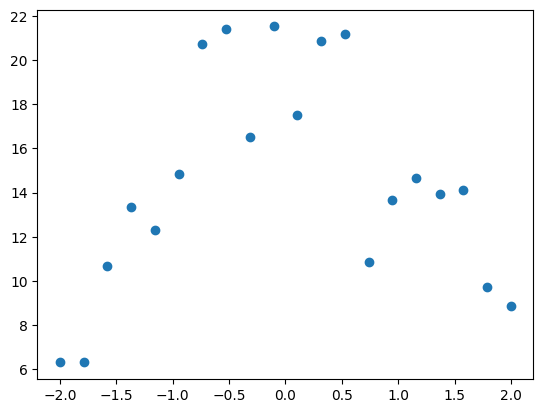

In [10]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);
'''
Â•ΩÁöÑÔºåËøôÈÉ®ÂàÜ‰ª£Á†ÅÂÖ∑‰ΩìÂê´‰πâÂíå‰ΩúÁî®Â¶Ç‰∏ãÔºö

---

### 1. `x = np.linspace(-2, 2, num=20)[:, None]`

* `np.linspace(-2, 2, num=20)`
  ËøôÂè•‰ª£Á†ÅÁöÑ‰ΩúÁî®ÊòØÁîüÊàê‰∏Ä‰∏™**Á≠âÈó¥Ë∑ùÁöÑ‰∏ÄÁª¥Êï∞ÁªÑ**ÔºåËåÉÂõ¥‰ªé -2 Âà∞ 2ÔºåÊÄªÂÖ±Êúâ 20 ‰∏™ÁÇπ„ÄÇ
  ‰æãÂ¶ÇÔºö`[-2.0, -1.789..., ..., 1.789..., 2.0]`

* `[:, None]`
  Ëøô‰∏ÄÊ≠•ÊòØÂ∞Ü‰∏ÄÁª¥Êï∞ÁªÑËΩ¨Êç¢‰∏∫‰∫åÁª¥Êï∞ÁªÑÁöÑÂΩ¢ÂºèÔºåÂèòÊàê‰∏Ä‰∏™ 20 Ë°å 1 ÂàóÁöÑÊï∞ÁªÑ„ÄÇ
  ËøôÊ†∑ÂÅöÁöÑÁõÆÁöÑÊòØËÆ© `x` Êàê‰∏∫‰∏Ä‰∏™‰∫åÁª¥ÂàóÂêëÈáèÔºåÂΩ¢Áä∂ÊòØ `(20, 1)`ÔºåÊñπ‰æøÂêéÁª≠ÂÅöÁü©ÈòµËøêÁÆóÂíåÂπøÊí≠„ÄÇ

---

### 2. `y = add_noise(f(x), 0.2, 1.3)`

* `f(x)`
  Ë∞ÉÁî®‰πãÂâçÂÆö‰πâÁöÑÂáΩÊï∞ `f`Ôºà‰æãÂ¶ÇÔºö`f(x) = -3*x**2 + 2*x + 20`ÔºâÔºåÂØπÊØè‰∏™ `x` ÂÄºËÆ°ÁÆóÂØπÂ∫îÁöÑÂáΩÊï∞ÂÄºÔºåÁîüÊàêÂØπÂ∫îÁöÑ y ÂùêÊ†á„ÄÇ

* `add_noise(f(x), 0.2, 1.3)`
  Ëøô‰∏™ÂáΩÊï∞Âú® `f(x)` ÁöÑÂü∫Á°Ä‰∏äÊ∑ªÂä†‚ÄúÂô™Â£∞‚ÄùÔºåÊ®°ÊãüÁé∞ÂÆûÊµãÈáè‰∏≠ÁöÑÈöèÊú∫ËØØÂ∑Æ„ÄÇ

  * `0.2` Âíå `1.3` ÊòØÊéßÂà∂Âô™Â£∞Âº∫Â∫¶ÁöÑÂèÇÊï∞ÔºàÂàÜÂà´Áî®‰∫é‰πòÊ≥ïÂíåÂä†Ê≥ïÂô™Â£∞Ôºâ„ÄÇ
  * ËøîÂõûÁöÑÊòØÂä†Âô™ÂêéÁöÑ y ÂÄºÊï∞ÁªÑ„ÄÇ

---

### 3. `plt.scatter(x, y);`

* ‰ΩøÁî® `matplotlib.pyplot.scatter` ÂáΩÊï∞ÁªòÂà∂Êï£ÁÇπÂõæÔºå
* Ê®™ÂùêÊ†áÊòØ `x`ÔºåÁ∫µÂùêÊ†áÊòØÂä†Âô™ÂêéÁöÑ `y`Ôºå
* Áî®ÁÇπÁöÑÂΩ¢ÂºèÊòæÁ§∫Êï∞ÊçÆÔºåÁõ¥ËßÇÂèçÊò†Â∏¶Âô™Â£∞ÁöÑÂáΩÊï∞ÂÄºÂàÜÂ∏É„ÄÇ

---

### ÊÄªÁªì

* `x` ÊòØ 20 ‰∏™ÂùáÂåÄÂàÜÂ∏ÉÂú® \[-2, 2] ‰πãÈó¥ÁöÑÁÇπÔºåËΩ¨Êàê‰∫ÜÂàóÂêëÈáèÂΩ¢Âºè„ÄÇ
* `y` ÊòØÂØπ `f(x)` ËÆ°ÁÆóÁªìÊûúÂä†‰∫ÜÂô™Â£∞ÂêéÁöÑÂÄºÔºåÊ®°ÊãüÁúüÂÆû‰∏ñÁïåÊï∞ÊçÆ„ÄÇ
* `plt.scatter(x, y)` Â∞ÜËøô‰∫õÂ∏¶ÊúâÂô™Â£∞ÁöÑÊï∞ÊçÆÁÇπÁîªÂá∫Êù•ÔºåËßÇÂØüÂÆÉ‰ª¨ÁöÑÂàÜÂ∏ÉÂíåÂáΩÊï∞Ë∂ãÂäø„ÄÇ

ËøôÊÆµ‰ª£Á†ÅÁöÑÊï¥‰ΩìÊïàÊûúÂ∞±ÊòØÁªòÂà∂‰∏Ä‰∏™ÊúâÈöèÊú∫Êâ∞Âä®ÁöÑÂáΩÊï∞Êï£ÁÇπÂõæÔºå‰æø‰∫éÁêÜËß£Êï∞ÊçÆÁöÑÊ≥¢Âä®ÊÄßÂíåË∂ãÂäø„ÄÇ

---

Â¶ÇÊûú‰Ω†ÈúÄË¶ÅÔºåÊàë‰πüÂèØ‰ª•Â∏Æ‰Ω†ÂÜôËøôÊÆµ‰ª£Á†ÅÁöÑÂÆåÊï¥ËøêË°åÁ§∫‰æã„ÄÇ

'''

Now let's see what happens if we *underfit* or *overfit*(Ê¨†ÊãüÂêàÔºàunderfitÔºâÔºöÊ®°ÂûãÂ§çÊùÇÂ∫¶‰ΩéÔºåÊó†Ê≥ïÂáÜÁ°ÆÊçïÊçâÊï∞ÊçÆËßÑÂæãÔºåÊãüÂêàÊïàÊûúÂ∑Æ„ÄÇ

ËøáÊãüÂêàÔºàoverfitÔºâÔºöÊ®°ÂûãÂ§çÊùÇÂ∫¶ËøáÈ´òÔºåÊãüÂêàËÆ≠ÁªÉÊï∞ÊçÆËøáÂ•ΩÔºåÂØºËá¥Ê≥õÂåñËÉΩÂäõÂ∑ÆÔºåÈ¢ÑÊµãÊñ∞Êï∞ÊçÆÊó∂Ë°®Áé∞‰∏çÂ•Ω„ÄÇ

‰æãÂ¶ÇÔºö‰∏ÄÊ¨°Â§öÈ°πÂºèÊòØÁ∫øÊÄßÊ®°ÂûãÔºå‰∫åÊ¨°ÊòØÊäõÁâ©Á∫øÔºå‰∏âÊ¨°ÊòØ‰∏âÊ¨°Êõ≤Á∫øÔºåÁ≠âÁ≠â„ÄÇ) these predictions. To do that, we'll create a function that fits a polynomial of some degree (e.g. a line is degree 1, quadratic is degree 2, cubic is degree 3, etc). The details of how this function works don't matter too much so feel free to skip over it if you like!  (PS: if you're not sure about the jargon around polynomials, here's a [great video](https://www.youtube.com/watch?v=ffLLmV4mZwU) which teaches you what you'll need to know.)



---

### 1. ‰ªÄ‰πàÊòØ**Â§öÈ°πÂºèÂõûÂΩí**Ôºü

* **ÂõûÂΩí**ÔºåÁÆÄÂçïËØ¥Â∞±ÊòØÁî®Êï∞Â≠¶ÊñπÊ≥ïÊâæÂà∞Êï∞ÊçÆ‰πãÈó¥ÁöÑ‚ÄúËßÑÂæã‚ÄùÊàñ‚ÄúÂÖ≥Á≥ª‚Äù„ÄÇ
* **Â§öÈ°πÂºèÂõûÂΩí**ÊòØÂõûÂΩíÁöÑ‰∏ÄÁßçÔºåÂÆÉÁî®‚ÄúÂ§öÈ°πÂºèÂáΩÊï∞‚ÄùÔºàÊØîÂ¶Ç $y = ax^2 + bx + c$ ËøôÁßçÊõ≤Á∫øÔºâÊù•ÊãüÂêàÊï∞ÊçÆÁÇπ„ÄÇ
* ÊØîÂ¶ÇÔºå‰Ω†Êúâ‰∏Ä‰∫õÊï£ËêΩÁöÑÁÇπÔºå‰Ω†ÊÉ≥Êâæ‰∏ÄÊù°Êõ≤Á∫øÂ∞ΩÂèØËÉΩÈù†ËøëËøô‰∫õÁÇπÔºåËøôÊù°Êõ≤Á∫øÂ∞±ÊòØÂ§öÈ°πÂºèÂõûÂΩíÁöÑÁªìÊûú„ÄÇ

---

### 2. ËøôÈáåÁöÑ $x$ Âíå $y$ ÊòØ‰ªÄ‰πàÔºü

* ‰Ω†ÂèØ‰ª•ÊääÂÆÉÁêÜËß£ÊàêÊï∞ÊçÆË°®ÈáåÁöÑ‰∏§ÂàóÊï∞ÊçÆÔºåÊØîÂ¶ÇÔºö

  * $x$ÔºöÊàøÂ≠êÁöÑÈù¢ÁßØ„ÄÅÊó∂Èó¥„ÄÅÂπ¥ÈæÑÁ≠â‚ÄúËæìÂÖ•‚ÄùÊï∞ÊçÆ
  * $y$ÔºöÂØπÂ∫îÁöÑÊàø‰ª∑„ÄÅÊ∏©Â∫¶„ÄÅÊî∂ÂÖ•Á≠â‚ÄúËæìÂá∫‚ÄùÁªìÊûú
* ‰Ω†ÁöÑ‰ªªÂä°ÊòØÔºöÊ†πÊçÆ $x$ ÁöÑÊï∞ÂÄºÔºåÈ¢ÑÊµã $y$ ÊòØÂ§öÂ∞ë„ÄÇ

---

### 3. ‰ªÄ‰πàÊòØ**Ê¨†ÊãüÂêàÔºàunderfittingÔºâ**Ôºü

* **Ê¨†ÊãüÂêà**Â∞±ÂÉèÁî®‰∏ÄÊ†πÁõ¥Á∫øÂéªÊãüÂêà‰∏Ä‰∏™ÂºØÊõ≤ÁöÑÊï£ÁÇπÂõæÔºåÁõ¥Á∫øÊ†πÊú¨‚ÄúË¥¥‚Äù‰∏ç‰∏äËøô‰∫õÁÇπÔºåËßÑÂæãÊ≤°ÊâæÂá∫Êù•„ÄÇ
* ÂéüÂõ†ÊòØ‰Ω†Áî®ÁöÑÊ®°ÂûãÂ§™ÁÆÄÂçï‰∫ÜÔºåÊ≤°ÂäûÊ≥ïÊçïÊçâÊï∞ÊçÆÁöÑÂèòÂåñ„ÄÇ
* ÁªìÊûúÊòØÈ¢ÑÊµã‰∏çÂáÜÁ°ÆÔºåÂØπÊï∞ÊçÆÁöÑÁêÜËß£Âæà‚ÄúÊµÖ‚Äù„ÄÇ

---

### 4. ‰ªÄ‰πàÊòØ**ËøáÊãüÂêàÔºàoverfittingÔºâ**Ôºü

* **ËøáÊãüÂêà**ÊòØÁî®‰∏ÄÊù°‚ÄúË∂ÖÁ∫ßÂ§çÊùÇ‚ÄùÁöÑÊõ≤Á∫øÂéª‚ÄúÊ≠ªÊ≠ªË¥¥‰Ωè‚ÄùÊØè‰∏™ÁÇπÔºåÂì™ÊÄïÊòØÂô™Â£∞ÂíåÂÅ∂ÁÑ∂ÁöÑÊ≥¢Âä®‰πüË∑üÁùÄÂ≠¶„ÄÇ
* ËøôÁßçÊõ≤Á∫øÂú®ËÆ≠ÁªÉÊï∞ÊçÆ‰∏äË°®Áé∞ÂÆåÁæéÔºå‰ΩÜÂØπÊñ∞Êï∞ÊçÆÈ¢ÑÊµãÂç¥ÂæàÁ≥üÁ≥ï„ÄÇ
* ËøáÊãüÂêàÂ∞±ÂÉè‰Ω†Âú®ËÄÉËØïËÉå‰∫ÜÊï¥Êú¨‰π¶Ôºå‰ΩÜÂè™‰ºö‚ÄúÊ≠ªËÆ∞Á°¨ËÉå‚ÄùÔºå‰∏çÊáÇÂæóÁÅµÊ¥ªËøêÁî®„ÄÇ

---

### ÊÄªÁªì‰∏Ä‰∏ã

* Â§öÈ°πÂºèÂõûÂΩíÂ∞±ÊòØÊâæ‰∏ÄÊù°Êõ≤Á∫øÔºåËÆ©ÂÆÉÂ∞ΩÂèØËÉΩ‚ÄúË¥¥Âêà‚ÄùÂ∑≤Áü•Êï∞ÊçÆÁÇπ„ÄÇ
* Ê¨†ÊãüÂêàÔºöÊ®°ÂûãÂ§™ÁÆÄÂçïÔºåÊâæ‰∏çÂà∞ËßÑÂæã„ÄÇ
* ËøáÊãüÂêàÔºöÊ®°ÂûãÂ§™Â§çÊùÇÔºåÂ≠¶Âà∞‰∫Ü‚ÄúÂÅáËßÑÂæã‚ÄùÔºåÊ≥õÂåñËÉΩÂäõÂ∑Æ„ÄÇ
* ‰Ω†ÁöÑÁõÆÊ†áÊòØÊâæÂà∞‚ÄúÂàöÂàöÂ•Ω‚ÄùÁöÑÊ®°ÂûãÔºåÊó¢ËÉΩÂèçÊò†ËßÑÂæãÔºåÂèà‰∏çËøáÂ∫¶ÊãüÂêà„ÄÇ

---




In [11]:
from sklearn.linear_model import LinearRegression #Á∫øÊÄßÂõûÂΩíÊ®°ÂûãÔºåÊúÄÂü∫Á°ÄÁöÑÂõûÂΩíÁÆóÊ≥ï„ÄÇ
from sklearn.preprocessing import PolynomialFeatures #Â∞ÜËæìÂÖ•ÁâπÂæÅÊâ©Â±ïÊàêÂ§öÈ°πÂºèÁâπÂæÅÔºàÊØîÂ¶ÇÊää x ÂèòÊàê [1, x, x¬≤, x¬≥...]Ôºâ„ÄÇ
from sklearn.pipeline import make_pipeline #ÊµÅÊ∞¥Á∫øÂ∑•ÂÖ∑ÔºåÂèØ‰ª•ÊääÂ§ö‰∏™Ê≠•È™§ÂêàÊàê‰∏Ä‰∏™Êï¥‰ΩìÁöÑÊ®°ÂûãÔºåÊñπ‰æøË∞ÉÁî®„ÄÇ

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    #degree Â∞±ÊòØÂëäËØâÂÆÉÔºå‰Ω†ÊÉ≥Ë¶ÅÂá†‰∏™‚ÄúÂºØÊõ≤Á®ãÂ∫¶‚ÄùÔºå1 ÊòØÁõ¥Á∫øÔºå2 ÊòØ‰∫åÊ¨°Êõ≤Á∫øÔºå3 ÊòØ‰∏âÊ¨°Êõ≤Á∫øÔºåË∂äÂ§ßË∂äÂ§çÊùÇ„ÄÇ
    # Á¨¨‰∫å‰∏™ÈÉ®ÂàÜ LinearRegression() ÊòØÂ∏Æ‰Ω†ÊâæÂá∫Ëøô‰∫õÊï∞Â≠óÂíå
    # ùë¶‰πãÈó¥ÁöÑÊúÄ‰Ω≥‚ÄúÊê≠ÈÖç‚ÄùÔºåÊâæ‰∏ÄÊù°Êõ≤Á∫øÊúÄË¥¥ËøëÊï∞ÊçÆÁÇπ„ÄÇ
    model.fit(x, y)#Ëøô‰∏ÄÊ≠•ÊòØ‚ÄúËÆ≠ÁªÉ‚ÄùÔºåÂ∞±ÊòØËÆ©Êú∫Âô®Â≠¶‰ºöÊÄéÊ†∑Áî®xÂéªÈ¢ÑÊµãy,ÊâæÂà∞ÂØπÂêàÈÄÇÁöÑÊõ≤Á∫ø
    plt.scatter(x,y)#ÁîªÂá∫‰Ω†ÊâãÂ§¥ÁöÑÂÆûÈôÖÊï∞ÊçÆÁÇπÔºåÁÇπÁÇπ‰ª£Ë°®ÁúüÂÆûÁöÑÊµãÈáèÁªìÊûú„ÄÇ
    plot_function(model.predict)#Ëøô‰∏ÄÊ≠•ÊòØÁî®Â≠¶Âà∞ÁöÑÊú∫Âô®ÔºåÂ∏Æ‰Ω†È¢ÑÊµãÊØè‰∏™xÂØπÂ∫îÁöÑy,Âπ∂ÁîªÂá∫È¢ÑÊµãÊõ≤Á∫øÔºå‰πüÂ∞±ÊòØÁîªÂá∫Êú∫Âô®ÁªôÂá∫ÁöÑ‚ÄúÊãüÂêàÊõ≤Á∫ø‚Äù


‰Ω†Êúâ‰∏ÄÂ†ÜÊï£ËêΩÁöÑÁü≥Â§¥ÔºàÊï∞ÊçÆÁÇπÔºâÔºåÊÉ≥Áî®‰∏ÄÊù°Áª≥Â≠êÊääÂÆÉ‰ª¨‰∏≤Ëµ∑Êù•ÔºàÊâæÂà∞ËßÑÂæãÔºâ„ÄÇ

degree Â∞±ÊòØ‰Ω†ÂÖÅËÆ∏Áª≥Â≠êÂºØÂ§öÂ∞ëÊ¨°„ÄÇÁª≥Â≠êÂ§™Áõ¥ÔºåÂèØËÉΩ‰∏≤‰∏ç‰ΩèÊâÄÊúâÁü≥Â§¥ÔºàÊ¨†ÊãüÂêàÔºâ„ÄÇÁª≥Â≠êÂºØÂæóÂ§™Â§öÔºåÂèçËÄå‰ºöÁªïÂá∫ÊÄ™ÂúàÔºàËøáÊãüÂêàÔºâ„ÄÇ

ËøôÊÆµ‰ª£Á†ÅÂ∞±ÊòØÂ∏Æ‰Ω†ÊâæÂà∞ËøôÊ†∑‰∏ÄÊù°ÂêàÈÄÇÁöÑ‚ÄúÁª≥Â≠ê‚ÄùÔºåÁÑ∂ÂêéÂ∏Æ‰Ω†ÊääÂÆÉÁîªÂá∫Êù•

ÂÆÉÁöÑÁõÆÁöÑÊòØÂ∏Æ‰Ω†‚ÄúÁîª‰∏ÄÊù°Êõ≤Á∫ø‚ÄùÔºåËøôÊù°Êõ≤Á∫øÊòØÊ†πÊçÆ‰Ω†ÊâãÂ§¥ÁöÑÊï∞ÊçÆÁÇπ
ùë•
,
ùë¶
x,y ÊãüÂêàÂá∫Êù•ÁöÑ„ÄÇ
‰Ω†ÂèØ‰ª•ÊéßÂà∂ËøôÊù°Êõ≤Á∫øÁöÑ‚ÄúÂºØÊõ≤Á®ãÂ∫¶‚ÄùÔºàdegreeÔºâÔºå‰ªéËÄåÁúãÁúãÂÆÉÂíåÊï∞ÊçÆÁÇπÁöÑÂêªÂêàÊÉÖÂÜµ„ÄÇ

So, what happens if we fit a line (a "degree 1 polynomial") to our measurements?

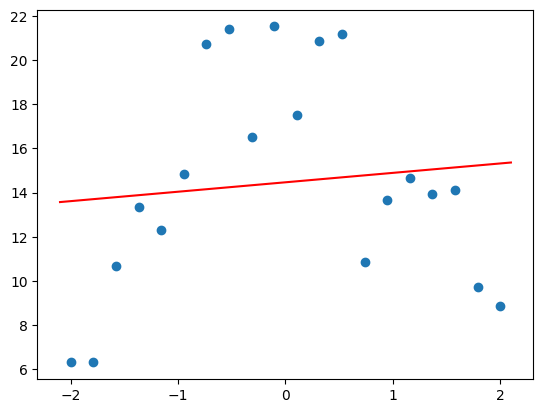

In [12]:
plot_poly(1)

As you see, the points on the red line (the line we fitted) aren't very close at all. This is *under-fit* -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

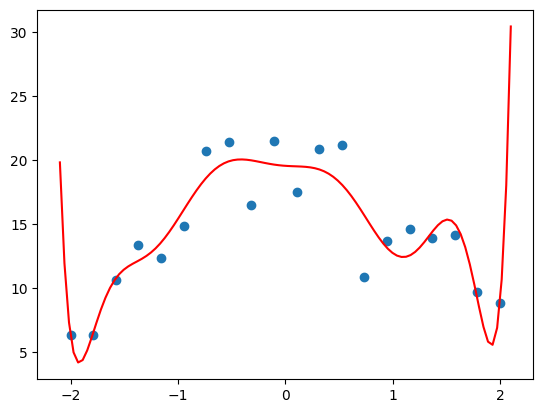

In [13]:
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is *over-fit* -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue):

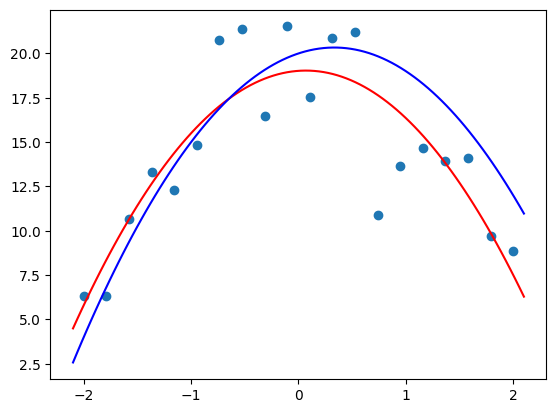

In [14]:
plot_poly(2)
plot_function(f, color='b')

That's not bad at all!

So, how do we recognise whether our models are under-fit, over-fit, or "just right"? We use a *validation set*. This is a set of data that we "hold out" from training -- we don't let our model see it at all. If you use the fastai library, it automatically creates a validation set for you if you don't have one, and will always report metrics (measurements of the accuracy of a model) using the validation set.

The validation set is *only* ever used to see how we're doing. It's *never* used as inputs to training the model.

Transformers uses a `DatasetDict` for holding your training and validation sets. To create one that contains 25% of our data for the validation set, and 75% for the training set, use `train_test_split`:

ÔºàValidation setÔºâÁöÑ‰ΩúÁî®

È™åËØÅÈõÜÊòØ‰ªéÊï∞ÊçÆ‰∏≠‚ÄúÁïôÂá∫Êù•‚ÄùÁöÑ‰∏ÄÈÉ®ÂàÜÔºå‰∏çÂèÇ‰∏éÊ®°ÂûãËÆ≠ÁªÉ„ÄÇ

‰ΩúÁî®ÊòØÁî®Êù•ËØÑ‰º∞Ê®°ÂûãÂú®‚ÄúÊú™ËßÅËøáÁöÑÊï∞ÊçÆ‚Äù‰∏äÁöÑË°®Áé∞Ôºå‰ªéËÄåÂà§Êñ≠Ê®°ÂûãÊòØÂê¶Ê¨†ÊãüÂêàÊàñËøáÊãüÂêà„ÄÇ

‰∏çËÉΩÊääÈ™åËØÅÈõÜÊï∞ÊçÆÁî®‰∫éËÆ≠ÁªÉÔºåÂè™Áî®‰∫éÊ£ÄÊµãÊ®°ÂûãÊïàÊûú

In [15]:
dds = tok_ds.train_test_split(0.25, seed=42)#train_test_split(0.25)‰æãÂ¶Ç25%È™åËØÅÈõÜÔºå75%ËÆ≠ÁªÉÈõÜÔºâÂàíÂàÜ„ÄÇ
dds

NameError: name 'tok_ds' is not defined

seedÔºàÈöèÊú∫ÁßçÂ≠êÔºâÂπ∂‰∏çÊòØÁõ¥Êé•‚ÄúÊåâËßÑÂæãÂàÜÈÖçÂºÇÂ∏∏ÁÇπ‚ÄùÔºåËÄåÊòØÂõ∫ÂÆö‰∫ÜÈöèÊú∫ÂàíÂàÜÁöÑËµ∑ÁÇπ„ÄÇ

Ëøô‰∏™‚ÄúËµ∑ÁÇπ‚Äù‰ºöÂÜ≥ÂÆöÊØèÊ¨°ÈöèÊú∫ÂàÜÈÖçÊï∞ÊçÆÔºàÂåÖÊã¨ÂºÇÂ∏∏ÁÇπÂíåÊ≠£Â∏∏ÁÇπÔºâÂà∞ËÆ≠ÁªÉÈõÜÂíåÈ™åËØÅÈõÜÁöÑÂÖ∑‰ΩìÊñπÂºè„ÄÇ

Âè™Ë¶Åseed‰∏çÂèòÔºåÂàÜÈÖçÁªìÊûúÔºàÂì™Êù°Êï∞ÊçÆÂéªËÆ≠ÁªÉÈõÜÔºåÂì™Êù°Êï∞ÊçÆÂéªÈ™åËØÅÈõÜÔºâÂ∞±ÊØèÊ¨°ÈÉΩÁõ∏ÂêåÔºåÊâÄ‰ª•ÂºÇÂ∏∏ÁÇπ‰πü‚ÄúÁ®≥ÂÆöÂú∞‚ÄùÂàÜÈÖçÂà∞Âêå‰∏ÄÈõÜÂêàÈáå„ÄÇ

Êç¢Âè•ËØùËØ¥Ôºö

ÈöèÊú∫ÂàíÂàÜÊòØÈöèÊú∫ÁöÑÔºå‰ΩÜ‰Ω†Áî®seedÊää‚ÄúÈöèÊú∫‚ÄùÈîÅÂÆöÊàêÂõ∫ÂÆöÁöÑ‰∏Ä‰∏™ÁªìÊûúÔºå‰øùËØÅÂºÇÂ∏∏ÁÇπÂíåÂÖ∂‰ªñÊï∞ÊçÆÊØèÊ¨°ÈÉΩÂú®Âêå‰∏ÄÈõÜÂêàÂá∫Áé∞ÔºåÊñπ‰æøÊ®°ÂûãÊïàÊûúÂØπÊØîÂíåÂ§çÁé∞„ÄÇ

As you see above, the validation set here is called `test` and not `validate`, so be careful!

In practice, a random split like we've used here might not be a good idea -- here's what Dr Rachel Thomas has to say about it:

> "*One of the most likely culprits for this disconnect between results in development vs results in production is a poorly chosen validation set (or even worse, no validation set at all). Depending on the nature of your data, choosing a validation set can be the most important step. Although sklearn offers a `train_test_split` method, this method takes a random subset of the data, which is a poor choice for many real-world problems.*"

I strongly recommend reading her article [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) to more fully understand this critical topic.

1. È™åËØÅÈõÜÂêçÁß∞ÂèØËÉΩ‰∏çÁªü‰∏Ä
‰Ω†‰πãÂâçÁúãÂà∞ÁöÑÊï∞ÊçÆÈõÜ‰∏≠ÔºåÈ™åËØÅÈõÜË¢´Âè´ÂÅö‚Äútest‚ÄùÔºàÊµãËØïÈõÜÔºâÔºåËÄå‰∏çÊòØ‚Äúvalidate‚ÄùÔºàÈ™åËØÅÈõÜÔºâ„ÄÇ

ËøôÊèêÈÜíÊàë‰ª¨Âú®ÂÆûÈôÖÊìç‰Ωú‰∏≠Ë¶ÅÊ≥®ÊÑèÊï∞ÊçÆÈõÜÂëΩÂêçÔºåÈÅøÂÖçÊ∑∑Ê∑ÜÈ™åËØÅÈõÜÂíåÊµãËØïÈõÜÁöÑÊ¶ÇÂøµ„ÄÇ

2. ÈöèÊú∫ÂàíÂàÜÈ™åËØÅÈõÜÂèØËÉΩ‰∏çÈÄÇÂêàÂÆûÈôÖÂ∫îÁî®
‰∏äÈù¢‰ª£Á†Å‰∏≠ÈááÁî®ÁöÑÈöèÊú∫ÂàíÂàÜÊñπÊ≥ïÔºàÊØîÂ¶Ç train_test_splitÔºâËôΩÁÑ∂Êñπ‰æøÔºå‰ΩÜÂú®ÂæàÂ§öÁúüÂÆûÂú∫ÊôØ‰∏ãÂπ∂‰∏çÊòØÁêÜÊÉ≥ÈÄâÊã©„ÄÇ

ËøôÁßçÈöèÊú∫ÂàíÂàÜÂèØËÉΩÂØºËá¥ËÆ≠ÁªÉÊó∂ÂíåÂÆûÈôÖÁîü‰∫ßÁéØÂ¢É‰∏≠ÁöÑÊï∞ÊçÆÂàÜÂ∏É‰∏ç‰∏ÄËá¥ÔºåËøõËÄåÂØºËá¥Ê®°ÂûãÊïàÊûúÂ∑ÆË∑ùËæÉÂ§ß„ÄÇ

3. Rachel Thomas ÁöÑËßÇÁÇπ
Â•πÊåáÂá∫ÔºåÈ™åËØÅÈõÜÁöÑÈÄâÊã©ÂØπÊ®°ÂûãË°®Áé∞Ëá≥ÂÖ≥ÈáçË¶ÅÔºåÈîôËØØÈÄâÊã©ÊàñÊ†πÊú¨Ê≤°ÊúâÈ™åËØÅÈõÜÈÉΩ‰ºö‰∏•ÈáçÂΩ±ÂìçÊ®°ÂûãÁöÑÊ≥õÂåñËÉΩÂäõ„ÄÇ

ÈöèÊú∫ÊäΩÂèñ‰∏ÄÈÉ®ÂàÜÊï∞ÊçÆ‰Ωú‰∏∫È™åËØÅÈõÜÔºåÂèØËÉΩÂπ∂‰∏çËÉΩ‰ª£Ë°®Êú™Êù•ÁúüÂÆûÁéØÂ¢É‰∏≠ÁöÑÊï∞ÊçÆÔºåÂØºËá¥Ê®°ÂûãÂú®ÂºÄÂèëÈò∂ÊÆµË°®Áé∞Â•ΩÔºå‰ΩÜ‰∏äÁ∫øÂêéÊïàÊûúÂèòÂ∑Æ„ÄÇ

4. Âª∫ËÆÆ
Êé®ËçêÈòÖËØª Rachel Thomas ÁöÑÊñáÁ´†„ÄäHow (and why) to create a good validation set„ÄãÔºåÊ∑±ÂÖ•‰∫ÜËß£Â¶Ç‰ΩïÁßëÂ≠¶ÂêàÁêÜÂú∞ÂàíÂàÜÈ™åËØÅÈõÜÔºå‰øùËØÅÊ®°ÂûãËØÑ‰º∞ÁöÑÊúâÊïàÊÄß„ÄÇ

ÊÄªÁªì
È™åËØÅÈõÜÁöÑÂàíÂàÜ‰∏çÊòØÈöèÊÑèÁöÑÔºåÂ∞§ÂÖ∂Âú®ÁúüÂÆûÂ§çÊùÇÁöÑÊï∞ÊçÆÁéØÂ¢É‰∏≠ÔºåÁßëÂ≠¶Âú∞ÈÄâÂèñÈ™åËØÅÈõÜÊòØ‰øùËØÅÊ®°ÂûãË¥®ÈáèÂíåÁ®≥ÂÆöÊÄßÁöÑÂÖ≥ÈîÆ‰∏ÄÊ≠•„ÄÇÁÆÄÂçïÁöÑÈöèÊú∫ÂàíÂàÜËôΩÁÑ∂Â∏∏Áî®Ôºå‰ΩÜÂèØËÉΩÂ∏¶Êù•ËØØÂØº

### Test set

So that's the validation set explained, and created. What about the "test set" then -- what's that for?

The *test set* is yet another dataset that's held out from training. But it's held out from reporting metrics too! The accuracy of your model on the test set is only ever checked after you've completed your entire training process, including trying different models, training methods, data processing, etc.

You see, as you try all these different things, to see their impact on the metrics on the validation set, you might just accidentally find a few things that entirely coincidentally improve your validation set metrics, but aren't really better in practice. Given enough time and experiments, you'll find lots of these coincidental improvements. That means you're actually over-fitting to your validation set!

That's why we keep a test set held back. Kaggle's public leaderboard is like a test set that you can check from time to time. But don't check too often, or you'll be even over-fitting to the test set!

Kaggle has a *second* test set, which is yet another held-out dataset that's only used at the *end* of the competition to assess your predictions. That's called the "private leaderboard". Here's a [great post](https://gregpark.io/blog/Kaggle-Psychopathy-Postmortem/) about what can happen if you overfit to the public leaderboard.

We'll use `eval` as our name for the test set, to avoid confusion with the `test` dataset that was created above.

In [ ]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

## Metrics and correlation

When we're training a model, there will be one or more *metrics* that we're interested in maximising or minimising. These are the measurements that should, hopefully, represent how well our model will works for us.

In real life, outside of Kaggle, things not easy... As my partner Dr Rachel Thomas notes in [The problem with metrics is a big problem for AI](https://www.fast.ai/2019/09/24/metrics/):

>  At their heart, what most current AI approaches do is to optimize metrics. The practice of optimizing metrics is not new nor unique to AI, yet AI can be particularly efficient (even too efficient!) at doing so. This is important to understand, because any risks of optimizing metrics are heightened by AI. While metrics can be useful in their proper place, there are harms when they are unthinkingly applied. Some of the scariest instances of algorithms run amok all result from over-emphasizing metrics. We have to understand this dynamic in order to understand the urgent risks we are facing due to misuse of AI.

In Kaggle, however, it's very straightforward to know what metric to use: Kaggle will tell you! According to this competition's [evaluation page](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview/evaluation), "*submissions are evaluated on the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) between the predicted and actual similarity scores*." This coefficient is usually abbreviated using the single letter *r*. It is the most widely used measure of the degree of relationship between two variables.

r can vary between `-1`, which means perfect inverse correlation, and `+1`, which means perfect positive correlation. The mathematical formula for it is much less important than getting a good intuition for what the different values look like. To start to get that intuition, let's look at some examples using the [California Housing](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) dataset, which shows "*is the median house value for California districts, expressed in hundreds of thousands of dollars*". This dataset is provided by the excellent [scikit-learn](https://scikit-learn.org/stable/) library, which is the most widely used library for machine learning outside of deep learning.

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

We can see all the correlation coefficients for every combination of columns in this dataset by calling `np.corrcoef`:

In [ ]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

This works well when we're getting a bunch of values at once, but it's overkill when we want a single coefficient:

In [ ]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

Therefore, we'll create this little function to just return the single number we need given a pair of variables:

In [ ]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

Now we'll look at a few examples of correlations, using this function (the details of the function don't matter too much):

In [ ]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

OK, let's check out the correlation between income and house value:

In [ ]:
show_corr(housing, 'MedInc', 'MedHouseVal')

So that's what a correlation of 0.68 looks like. It's quite a close relationship, but there's still a lot of variation. (Incidentally, this also shows why looking at your data is so important -- we can see clearly in this plot that house prices above $500,000 seem to have been truncated to that maximum value).

Let's take a look at another pair:

In [ ]:
show_corr(housing, 'MedInc', 'AveRooms')

The relationship looks like it is similarly close to the previous example, but r is much lower than the income vs valuation case. Why is that? The reason is that there are a lot of *outliers* -- values of `AveRooms` well outside the mean.

r is very sensitive to outliers. If there's outliers in your data, then the relationship between them will dominate the metric. In this case, the houses with a very high number of rooms don't tend to be that valuable, so it's decreasing r from where it would otherwise be.

Let's remove the outliers and try again:

In [ ]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

As we expected, now the correlation is very similar to our first comparison.

Here's another relationship using `AveRooms` on the subset:

In [ ]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

At this level, with r of 0.34, the relationship is becoming quite weak.

Let's look at one more:

In [ ]:
show_corr(subset, 'HouseAge', 'AveRooms')

As you see here, a correlation of -0.2 shows a very weak negative trend.

We've seen now examples of a variety of levels of correlation coefficient, so hopefully you're getting a good sense of what this metric means.

Transformers expects metrics to be returned as a `dict`, since that way the trainer knows what label to use, so let's create a function to do that:

In [ ]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

## Training our model

To train a model in Transformers we'll need this:

In [ ]:
from transformers import TrainingArguments,Trainer

We pick a batch size that fits our GPU, and small number of epochs so we can run experiments quickly:

In [ ]:
bs = 128
epochs = 4

The most important hyperparameter is the learning rate. fastai provides a learning rate finder to help you figure this out, but Transformers doesn't, so you'll just have to use trial and error. The idea is to find the largest value you can, but which doesn't result in training failing.

In [ ]:
lr = 8e-5

Transformers uses the `TrainingArguments` class to set up arguments. Don't worry too much about the values we're using here -- they should generally work fine in most cases. It's just the 3 parameters above that you may need to change for different models.

In [ ]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

We can now create our model, and `Trainer`, which is a class which combines the data and model together (just like `Learner` in fastai):

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

As you see, Transformers spits out lots of warnings. You can safely ignore them.

Let's train our model!

In [ ]:
trainer.train();

Lots more warning from Transformers again -- you can ignore these as before.

The key thing to look at is the "Pearson" value in table above. As you see, it's increasing, and is already above 0.8. That's great news! We can now submit our predictions to Kaggle if we want them to be scored on the official leaderboard. Let's get some predictions on the test set:

In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

Look out - some of our predictions are <0, or >1! This once again shows the value of remember to actually *look* at your data. Let's fix those out-of-bounds predictions:

In [ ]:
preds = np.clip(preds, 0, 1)

In [ ]:
preds

OK, now we're ready to create our submission file. If you save a CSV in your notebook, you will get the option to submit it later.

In [ ]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Unfortunately this is a *code competition* and internet access is disabled. That means the `pip install datasets` command we used above won't work if you want to submit to Kaggle. To fix this, you'll need to download the pip installers to Kaggle first, as [described here](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/113195). Once you've done that, disable internet in your notebook, go to the Kaggle leaderboards page, and click the *Submission* button.

## The end

Once you're ready to go deeper, take a look at my [Iterate Like a Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/) notebook.

Thanks for reading! This has been a bit of an experiment for me -- I've never done an "absolute beginners" guide before on Kaggle. I hope you like it! If you do, I'd greatly appreciate an upvote. Don't hesitate to add a comment if you have any questions or thoughts to add.